Libraries

In [1]:
!pip install ultralytics
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [13]:
from ultralytics import YOLO
from roboflow import Roboflow
import zipfile
import numpy as np
import itertools
import os
from IPython.display import display, Image
from IPython import display
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import shutil
from sklearn.model_selection import train_test_split
from collections import defaultdict

# **Dataset**

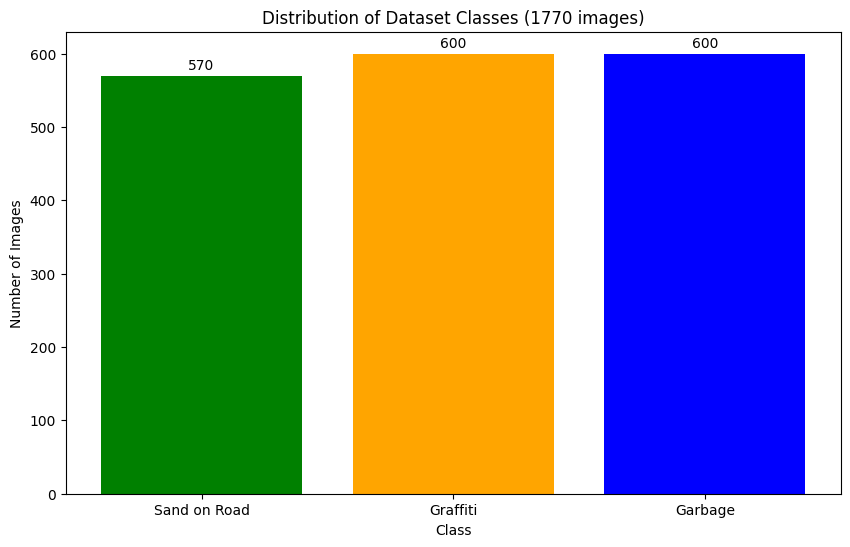

In [19]:
sand_on_road_count = len(os.listdir('/content/sand on road'))
graffiti_count =  len(os.listdir('/content/graffiti'))
garbage_count =  len(os.listdir('/content/garbage'))
n= sand_on_road_count + graffiti_count + garbage_count
categories = ['Sand on Road', 'Graffiti', 'Garbage']
counts = [sand_on_road_count, graffiti_count, garbage_count]

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=['green', 'orange', 'blue'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, str(yval), ha='center', va='bottom')

plt.title(f'Distribution of Dataset Classes ({n} images)')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


# **Augmentation**

Dataset extracted to: /content/sand_on_road_600


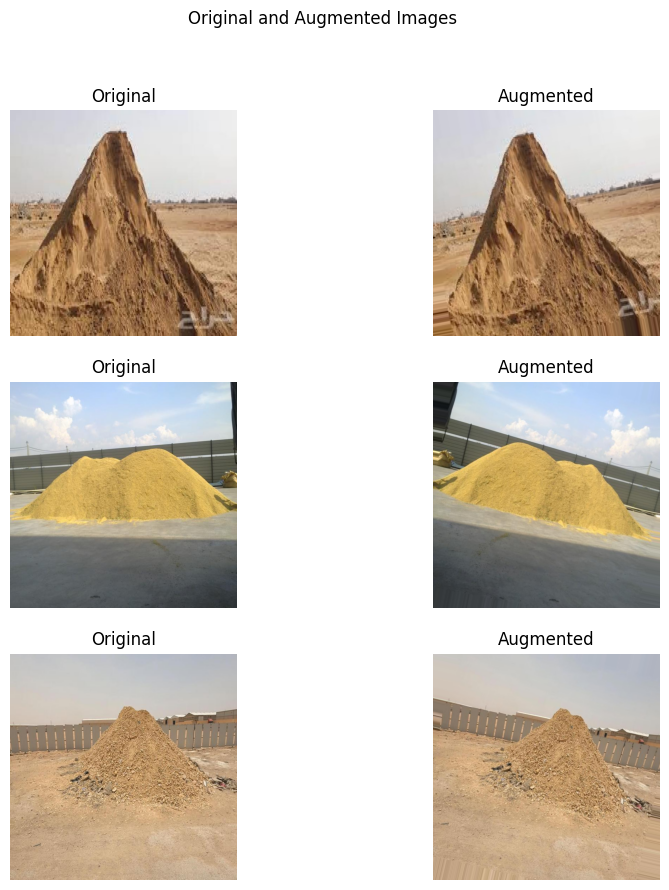

In [ ]:
zip_path = "/content/sand on road 600 (2).zip"
extracted_path = "/content/sand_on_road_600"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

print("Dataset extracted to:", extracted_path)

for root, dirs, files in os.walk(extracted_path):
    if files:
        original_images_dir = root
        break

datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    fill_mode='nearest'
)

plt.figure(figsize=(10, 10))
image_files = [f for f in os.listdir(original_images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

for i, img_name in enumerate(image_files[:3]):
    img_path = os.path.join(original_images_dir, img_name)

    img = load_img(img_path)
    img_array = img_to_array(img)

    plt.subplot(3, 2, 2 * i + 1)
    plt.imshow(np.array(img))
    plt.axis('off')
    plt.title("Original")

    augmented_image = next(datagen.flow(img_array.reshape((1,) + img_array.shape), batch_size=1))[0].astype('uint8')
    plt.subplot(3, 2, 2 * i + 2)
    plt.imshow(augmented_image)
    plt.axis('off')
    plt.title("Augmented")

plt.suptitle("Original and Augmented Images")
plt.show()

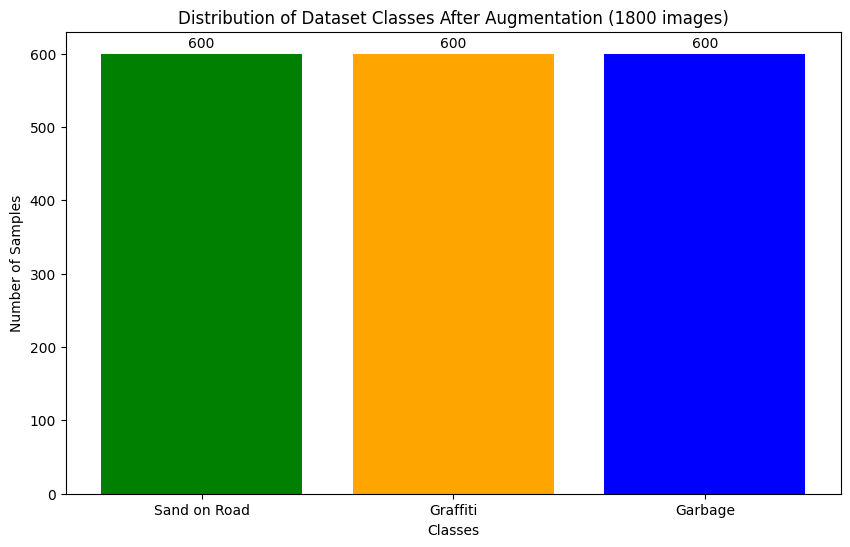

In [21]:
images_path = '/content/SP2-v2-2/train/images'
labels_path = '/content/SP2-v2-2/train/labels'
n = len(os.listdir(images_path))
overall_class_distribution = defaultdict(int)

all_labels = sorted(os.listdir(labels_path))
for label in all_labels:
    label_path = os.path.join(labels_path, label)
    with open(label_path, 'r') as f:
        class_id = int(f.readline().split()[0])  # Get the class from the first index
        overall_class_distribution[class_id] += 1

colors = ['blue', 'orange', 'green']
class_labels = {
    0: "Sand on Road",
    1: "Graffiti",
    2: "Garbage"
}

plt.figure(figsize=(10, 6))
bars = plt.bar(overall_class_distribution.keys(), overall_class_distribution.values(), color=colors)
plt.title(f'Distribution of Dataset Classes After Augmentation ({n} images)')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')

plt.xticks(list(overall_class_distribution.keys()), [class_labels.get(i, f'Class {i}') for i in overall_class_distribution.keys()])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, int(yval), ha='center', va='bottom')

plt.show()

# **Preprocessing**

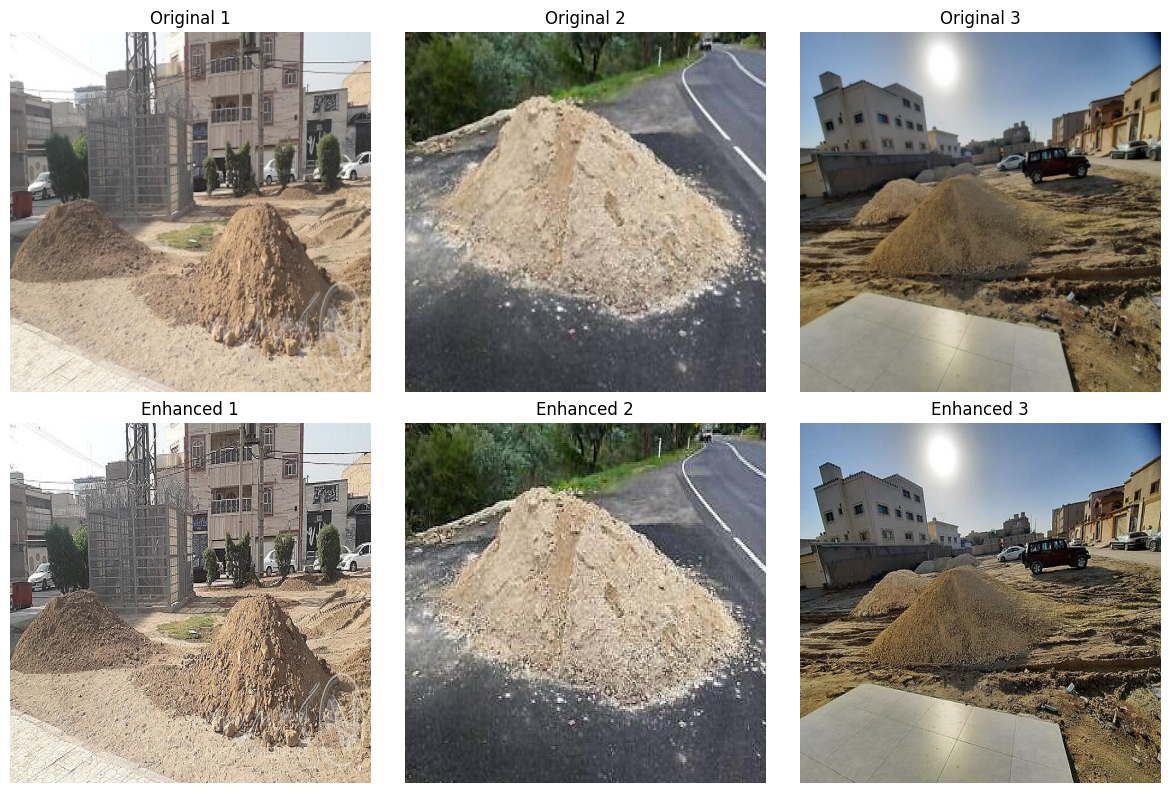

In [ ]:
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def sharpen_image(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

def resize_image(img, size=(640, 640)):
    return cv2.resize(img, size)

def show_images(original_images, enhanced_images):
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))

    for i, ax in enumerate(axs[0]):
        ax.imshow(original_images[i])
        ax.set_title(f"Original {i+1}")
        ax.axis('off')

    for i, ax in enumerate(axs[1]):
        ax.imshow(enhanced_images[i])
        ax.set_title(f"Enhanced {i+1}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def process_images_from_zip(zip_file_path, output_dir, final_zip_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

        image_paths = [os.path.join(output_dir, f) for f in zip_ref.namelist() if f.endswith(('.jpg', '.jpeg', '.png'))]

        original_images = []
        enhanced_images = []

        for image_path in image_paths:
            img = load_image(image_path)
            original_images.append(img)

            img_sharpened = sharpen_image(img)
            img_resized = resize_image(img_sharpened)

            base_name = os.path.basename(image_path)
            enhanced_image_path = os.path.join(output_dir, f"enhanced_{base_name}")
            enhanced_images.append(img_resized)
            cv2.imwrite(enhanced_image_path, cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))  # Save as BGR

        show_images(original_images[:3], enhanced_images[:3])

    with zipfile.ZipFile(final_zip_path, 'w') as final_zip:
        for enhanced_image_path in [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.startswith("enhanced_")]:
            final_zip.write(enhanced_image_path, os.path.basename(enhanced_image_path))

zip_file_path = '/content/sand on road 600 (2).zip'
output_dir = 'output_images_sand'
final_zip_path = 'enhanced_images_sand.zip'

os.makedirs(output_dir, exist_ok=True)

process_images_from_zip(zip_file_path, output_dir, final_zip_path)


In [ ]:
def resize_image(img, size=(640, 640)):
    return cv2.resize(img, size)

def resize_images_from_zip(zip_file_path, output_dir, final_zip_path, size=(640, 640)):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

        image_paths = [os.path.join(output_dir, f) for f in zip_ref.namelist() if f.endswith(('.jpg', '.jpeg', '.png'))]

        for image_path in image_paths:
            img = cv2.imread(image_path)
            if img is None:
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            resized_img = resize_image(img_rgb, size)

            base_name = os.path.basename(image_path)
            resized_image_path = os.path.join(output_dir, f"resized_{base_name}")
            resized_bgr = cv2.cvtColor(resized_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(resized_image_path, resized_bgr)

    with zipfile.ZipFile(final_zip_path, 'w') as final_zip:
        for root, _, files in os.walk(output_dir):
            for file in files:
                if file.startswith("resized_"):
                    file_path = os.path.join(root, file)
                    final_zip.write(file_path, os.path.basename(file_path))

zip_file_path = '/content/Graffiti-600 (2).zip'
output_dir = 'output_images'
final_zip_path = 'resized_images_graffiti.zip'

os.makedirs(output_dir, exist_ok=True)

resize_images_from_zip(zip_file_path, output_dir, final_zip_path)


In [ ]:
def resize_image(img, size=(640, 640)):
    return cv2.resize(img, size)

def resize_images_from_zip(zip_file_path, output_dir, final_zip_path, size=(640, 640)):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

        image_paths = [os.path.join(output_dir, f) for f in zip_ref.namelist() if f.endswith(('.jpg', '.jpeg', '.png'))]

        for image_path in image_paths:
            img = cv2.imread(image_path)
            if img is None:
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            resized_img = resize_image(img_rgb, size)

            base_name = os.path.basename(image_path)
            resized_image_path = os.path.join(output_dir, f"resized_{base_name}")
            resized_bgr = cv2.cvtColor(resized_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(resized_image_path, resized_bgr)

    with zipfile.ZipFile(final_zip_path, 'w') as final_zip:
        for root, _, files in os.walk(output_dir):
            for file in files:
                if file.startswith("resized_"):
                    file_path = os.path.join(root, file)
                    final_zip.write(file_path, os.path.basename(file_path))

zip_file_path = '/content/garbage (3).zip'
output_dir = 'output_images'
final_zip_path = 'resized_images_garbage.zip'

os.makedirs(output_dir, exist_ok=True)

resize_images_from_zip(zip_file_path, output_dir, final_zip_path)

# **Dataset Splitting**

In [3]:
rf = Roboflow(api_key="PeLzsH0367tLME6tgvcD")
project = rf.workspace("project-xomfd").project("sp2-v2")
version = project.version(2)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to SP2-v2-2 in yolov8:: 100%|██████████| 3606/3606 [00:03<00:00, 1200.37it/s]


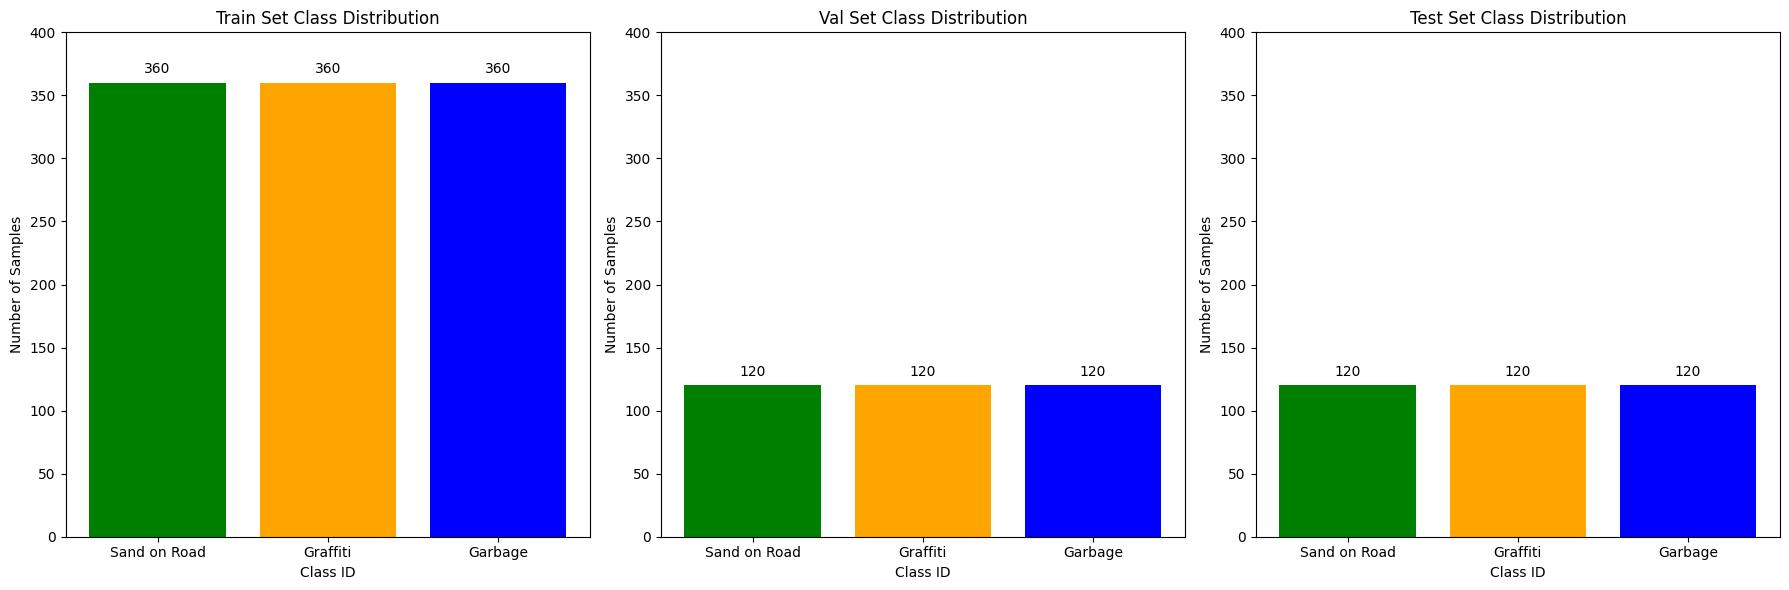

Dataset split and saved successfully!
Train Set: 1080 images
Valid Set: 360 images
Test Set: 360 images


In [ ]:
output_dirs = {
    'train': {'images': '/content/train/images', 'labels': '/content/train/labels'},
    'val': {'images': '/content/valid/images', 'labels': '/content/valid/labels'},
    'test': {'images': '/content/test/images', 'labels': '/content/test/labels'},
}

for group, paths in output_dirs.items():
    for key, path in paths.items():
        os.makedirs(path, exist_ok=True)

all_images = sorted(os.listdir(images_path))
all_labels = sorted(os.listdir(labels_path))

assert len(all_images) == len(all_labels), "Mismatch between images and labels count"

class_files = {}

for image, label in zip(all_images, all_labels):
    label_path = os.path.join(labels_path, label)
    with open(label_path, 'r') as f:
        class_id = int(f.readline().split()[0])  # Get the class from the first index

    if class_id not in class_files:
        class_files[class_id] = {'images': [], 'labels': []}

    class_files[class_id]['images'].append(image)
    class_files[class_id]['labels'].append(label)

samples_per_class = 600
train_size = int(0.6 * samples_per_class)
val_size = test_size = int(0.2 * samples_per_class)

distribution_counts = {'train': {}, 'val': {}, 'test': {}}

for class_id, files in class_files.items():
    class_images = files['images']
    class_labels = files['labels']

    if len(class_images) > samples_per_class:
        class_images = class_images[:samples_per_class]
        class_labels = class_labels[:samples_per_class]

    train_images, temp_images, train_labels, temp_labels = train_test_split(
        class_images, class_labels, train_size=train_size, random_state=42
    )
    val_images, test_images, val_labels, test_labels = train_test_split(
        temp_images, temp_labels, test_size=0.5, random_state=42
    )

    splits = {
        'train': (train_images, train_labels),
        'val': (val_images, val_labels),
        'test': (test_images, test_labels),
    }

    for split in splits:
        if class_id not in distribution_counts[split]:
            distribution_counts[split][class_id] = 0
        distribution_counts[split][class_id] += len(splits[split][0])

    for split, (images, labels) in splits.items():
        for image, label in zip(images, labels):
            shutil.copy(os.path.join(images_path, image), os.path.join(output_dirs[split]['images'], image))
            shutil.copy(os.path.join(labels_path, label), os.path.join(output_dirs[split]['labels'], label))

class_labels_map = {
    0: 'Sand on Road',
    1: 'Graffiti',
    2: 'Garbage'
}

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
split_names = ['train', 'val', 'test']
for i, split in enumerate(split_names):
    bars = ax[i].bar(distribution_counts[split].keys(), distribution_counts[split].values(), color=['blue', 'orange', 'green'])
    ax[i].set_title(f'{split.capitalize()} Set Class Distribution')
    ax[i].set_xlabel('Classes')
    ax[i].set_ylabel('Number of Samples')
    ax[i].set_xticks(list(distribution_counts[split].keys()))

    for bar in bars:
        height = bar.get_height()
        ax[i].text(bar.get_x() + bar.get_width() / 2, height + 5, str(int(height)), ha='center', va='bottom', fontsize=10)

    ax[i].set_xticklabels([class_labels_map.get(class_id, str(class_id)) for class_id in distribution_counts[split].keys()])

    ax[i].set_ylim(0, 400)

plt.tight_layout()
plt.show()

print("Dataset split and saved successfully!")
print("Train Set:", len(os.listdir("/content/train/images")), "images")
print("Valid Set:", len(os.listdir("/content/valid/images")), "images")
print("Test Set:", len(os.listdir("/content/test/images")), "images")

#**YOLOv8_m**

In [ ]:
yolo_m = YOLO('yolov8m.yaml').load('yolov8m.pt')
yolo_m.info()

100%|██████████| 49.7M/49.7M [00:00<00:00, 239MB/s]


Transferred 475/475 items from pretrained weights
YOLOv8m summary: 295 layers, 25,902,640 parameters, 25,902,624 gradients, 79.3 GFLOPs


(295, 25902640, 25902624, 79.3204224)

In [ ]:
print(yolo_m)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_

Training

In [ ]:
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [16, 32]
patiences = [10, 15]
epochs_list = [100]

param_grid = list(itertools.product(learning_rates, batch_sizes, patiences, epochs_list))

weights_dir = "best_weights"
os.makedirs(weights_dir, exist_ok=True)

best_mAP = 0
best_params = None
best_weights_path = None

for lr, batch, patience, epochs in param_grid:
    print(f"Training with lr={lr}, batch={batch}, patience={patience}, epochs={epochs}")

    # Train the model
    results = yolo_m.train(
        data='/content/data.yaml',
        epochs=epochs,
        imgsz=640,
        batch=batch,
        lr0=lr,
        patience=patience,
        cos_lr=True
    )

    current_mAP_50 = results.box.map50

    if current_mAP_50 > best_mAP:
        best_mAP = current_mAP_50
        best_params = (lr, batch, patience, epochs)
        best_weights_path = os.path.join(weights_dir, f"best_weights_lr{lr}_batch{batch}_epochs{epochs}_patience{patience}.pt")

        yolo_m.save(best_weights_path)

    print(f"Results for lr={lr}, batch={batch}, patience={patience}, epochs={epochs}: mAP={current_mAP_50:.4f}")

if best_params:
    print(f"Best mAP: {best_mAP:.4f} with parameters: lr={best_params[0]}, batch={best_params[1]}, patience={best_params[2]}, epochs={best_params[3]}")
    print(f"Best weights saved at: {best_weights_path}")
else:
    print("No successful training runs.")

Training with lr=0.001, batch=16, patience=10, epochs=100
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=yolov8m.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

100%|██████████| 755k/755k [00:00<00:00, 55.2MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 99.5MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<00:00, 1257.53it/s]

train: New cache created: /content/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/valid/labels... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<00:00, 1047.94it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.12G       1.47      2.374      1.797         24        640: 100%|██████████| 68/68 [00:11<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]

                   all        360        369      0.248      0.305      0.185     0.0585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.08G      1.679       1.89      1.935         26        640: 100%|██████████| 68/68 [00:09<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.84it/s]

                   all        360        369      0.198      0.284      0.135     0.0374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.15G      1.729      1.888      1.969         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.64it/s]

                   all        360        369     0.0675      0.204      0.056     0.0149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.05G      1.637      1.789      1.889         22        640: 100%|██████████| 68/68 [00:08<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.70it/s]

                   all        360        369      0.265      0.346      0.235     0.0866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.04G      1.592      1.711      1.854         21        640: 100%|██████████| 68/68 [00:08<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.77it/s]

                   all        360        369      0.508      0.536      0.506        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.07G      1.598      1.654      1.833         14        640: 100%|██████████| 68/68 [00:08<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.72it/s]

                   all        360        369      0.668       0.65      0.684      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.07G      1.549      1.614      1.822         16        640: 100%|██████████| 68/68 [00:08<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.62it/s]

                   all        360        369      0.526      0.574      0.531       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.07G      1.489      1.513      1.748         26        640: 100%|██████████| 68/68 [00:08<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.72it/s]

                   all        360        369      0.741       0.75      0.781      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.04G      1.471      1.474      1.745         23        640: 100%|██████████| 68/68 [00:08<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.70it/s]

                   all        360        369      0.748      0.704      0.743      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.06G       1.47      1.376      1.737         20        640: 100%|██████████| 68/68 [00:08<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.70it/s]

                   all        360        369      0.677      0.717      0.709      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.06G      1.446      1.412      1.717         18        640: 100%|██████████| 68/68 [00:08<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.66it/s]

                   all        360        369      0.807      0.746      0.814      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.04G      1.422      1.375      1.695         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.63it/s]

                   all        360        369      0.825      0.814      0.832      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.07G      1.411      1.337      1.703         14        640: 100%|██████████| 68/68 [00:08<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.72it/s]

                   all        360        369      0.713      0.717      0.748      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.07G      1.395      1.312      1.666         20        640: 100%|██████████| 68/68 [00:08<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.80it/s]

                   all        360        369      0.834      0.814      0.872      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.04G      1.377      1.269      1.673         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.76it/s]

                   all        360        369      0.693      0.721      0.726      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.08G      1.356      1.257      1.651         17        640: 100%|██████████| 68/68 [00:08<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.71it/s]

                   all        360        369      0.809      0.801      0.852      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.04G      1.372      1.229      1.655         17        640: 100%|██████████| 68/68 [00:08<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.80it/s]

                   all        360        369      0.836      0.801      0.855      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.06G      1.326      1.188      1.616         23        640: 100%|██████████| 68/68 [00:08<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.54it/s]

                   all        360        369      0.793      0.796      0.844      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.07G      1.337      1.186      1.642         20        640: 100%|██████████| 68/68 [00:08<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.84it/s]

                   all        360        369       0.82      0.782      0.848      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.04G      1.317      1.137      1.624         18        640: 100%|██████████| 68/68 [00:08<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.72it/s]

                   all        360        369      0.809      0.832      0.866       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.07G       1.35      1.197      1.658         20        640: 100%|██████████| 68/68 [00:08<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.78it/s]

                   all        360        369      0.777      0.705      0.756       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.04G      1.301      1.132       1.61         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.54it/s]

                   all        360        369      0.851      0.799      0.866      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.04G      1.291      1.112      1.609         21        640: 100%|██████████| 68/68 [00:08<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.89it/s]

                   all        360        369       0.84      0.835      0.876      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.04G      1.291      1.125      1.596         15        640: 100%|██████████| 68/68 [00:08<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.75it/s]

                   all        360        369      0.847       0.81      0.886      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.04G      1.251      1.081      1.584         21        640: 100%|██████████| 68/68 [00:08<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.59it/s]

                   all        360        369      0.853      0.807      0.892      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.04G      1.291      1.086      1.585         17        640: 100%|██████████| 68/68 [00:08<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.82it/s]

                   all        360        369      0.837      0.862      0.902      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.04G      1.243      1.067       1.58         14        640: 100%|██████████| 68/68 [00:08<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.78it/s]

                   all        360        369      0.852      0.853      0.889        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.07G      1.259      1.057      1.577         16        640: 100%|██████████| 68/68 [00:08<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.83it/s]

                   all        360        369      0.835      0.737      0.825       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.04G      1.262      1.041      1.588         18        640: 100%|██████████| 68/68 [00:08<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.47it/s]

                   all        360        369      0.893      0.851      0.912      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.04G      1.247       1.04      1.546         18        640: 100%|██████████| 68/68 [00:08<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.79it/s]

                   all        360        369      0.818      0.814      0.869      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.04G      1.239     0.9939      1.556         23        640: 100%|██████████| 68/68 [00:08<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.75it/s]

                   all        360        369      0.858       0.83      0.901      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.04G      1.237     0.9916      1.551         23        640: 100%|██████████| 68/68 [00:08<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.71it/s]

                   all        360        369      0.882      0.876       0.92      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.04G      1.228      1.012      1.557         22        640: 100%|██████████| 68/68 [00:08<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.52it/s]

                   all        360        369      0.875      0.857      0.913      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.07G      1.255     0.9894      1.575         16        640: 100%|██████████| 68/68 [00:08<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.82it/s]

                   all        360        369      0.879      0.854      0.896      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.07G        1.2     0.9923      1.529         21        640: 100%|██████████| 68/68 [00:08<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.80it/s]

                   all        360        369      0.854      0.794      0.859      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.04G      1.194     0.9772      1.524         13        640: 100%|██████████| 68/68 [00:08<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.73it/s]

                   all        360        369       0.87      0.885      0.924      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.08G      1.186     0.9808      1.526         11        640: 100%|██████████| 68/68 [00:08<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.67it/s]

                   all        360        369      0.894      0.831      0.923      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.04G      1.201      0.962      1.513         23        640: 100%|██████████| 68/68 [00:08<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.59it/s]

                   all        360        369      0.886       0.87      0.923      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.04G      1.206     0.9493      1.521         23        640: 100%|██████████| 68/68 [00:08<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.72it/s]

                   all        360        369      0.863       0.88      0.932      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.04G      1.221     0.9864      1.534         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.73it/s]

                   all        360        369      0.892      0.886      0.935      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.07G      1.216     0.9468      1.541         18        640: 100%|██████████| 68/68 [00:08<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.84it/s]

                   all        360        369      0.907      0.891      0.934      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.04G      1.164     0.8981      1.513         18        640: 100%|██████████| 68/68 [00:08<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.85it/s]

                   all        360        369      0.862      0.884      0.926      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.04G      1.164     0.9017      1.503         14        640: 100%|██████████| 68/68 [00:08<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.61it/s]

                   all        360        369      0.853      0.868      0.917       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.04G      1.157     0.9129      1.502         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.76it/s]

                   all        360        369       0.84      0.865      0.908      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.04G      1.179     0.8978      1.517         16        640: 100%|██████████| 68/68 [00:08<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.76it/s]

                   all        360        369      0.874      0.867      0.906      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.04G      1.149      0.865      1.494         22        640: 100%|██████████| 68/68 [00:08<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.78it/s]

                   all        360        369      0.869       0.88      0.914      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.07G      1.141     0.8879      1.467         18        640: 100%|██████████| 68/68 [00:08<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.72it/s]

                   all        360        369      0.946      0.841      0.927      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.07G      1.122     0.8619      1.478         25        640: 100%|██████████| 68/68 [00:08<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.65it/s]

                   all        360        369      0.894      0.876      0.925      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.04G      1.124     0.8425      1.476         20        640: 100%|██████████| 68/68 [00:09<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.86it/s]

                   all        360        369      0.877      0.873      0.918      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.04G      1.122     0.8317       1.48         26        640: 100%|██████████| 68/68 [00:08<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.80it/s]

                   all        360        369      0.896      0.884      0.928      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.04G      1.128      0.862      1.479         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.86it/s]

                   all        360        369      0.911      0.887      0.941      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.07G      1.117     0.8361      1.457         17        640: 100%|██████████| 68/68 [00:08<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.91it/s]

                   all        360        369      0.874      0.922      0.921      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.04G      1.095     0.8129      1.455         16        640: 100%|██████████| 68/68 [00:08<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.73it/s]

                   all        360        369      0.905      0.893       0.94      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.07G      1.082     0.8184      1.446         14        640: 100%|██████████| 68/68 [00:08<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.82it/s]

                   all        360        369      0.898      0.916       0.93      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.04G      1.077      0.819       1.45         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.84it/s]

                   all        360        369      0.917      0.861      0.937      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.04G      1.086     0.8247      1.456         17        640: 100%|██████████| 68/68 [00:08<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.86it/s]

                   all        360        369      0.899      0.884      0.936      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.04G      1.074     0.8225      1.438         23        640: 100%|██████████| 68/68 [00:08<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.82it/s]

                   all        360        369      0.906      0.894      0.935      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.04G      1.066     0.7921      1.436         16        640: 100%|██████████| 68/68 [00:08<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.83it/s]

                   all        360        369      0.881      0.908      0.935      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.04G      1.079     0.7821      1.436         16        640: 100%|██████████| 68/68 [00:08<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.53it/s]

                   all        360        369      0.918      0.901      0.947      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.04G      1.071     0.7882      1.447         23        640: 100%|██████████| 68/68 [00:08<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.62it/s]

                   all        360        369      0.884      0.906      0.932      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.07G       1.04     0.7664      1.415         21        640: 100%|██████████| 68/68 [00:08<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.76it/s]

                   all        360        369      0.897      0.896      0.938        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.07G       1.03     0.7873      1.414         23        640: 100%|██████████| 68/68 [00:08<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.81it/s]

                   all        360        369       0.89      0.907      0.947      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.07G      1.033     0.7459      1.409         21        640: 100%|██████████| 68/68 [00:08<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.88it/s]

                   all        360        369      0.886      0.911      0.933      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.04G      1.038     0.7485       1.39         27        640: 100%|██████████| 68/68 [00:08<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.86it/s]

                   all        360        369      0.904       0.91      0.944      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.07G       1.02     0.7308        1.4         22        640: 100%|██████████| 68/68 [00:08<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.90it/s]

                   all        360        369      0.899      0.911      0.942      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.07G       1.03     0.7442      1.419         14        640: 100%|██████████| 68/68 [00:08<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.94it/s]

                   all        360        369      0.911       0.89      0.935       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.04G      1.006      0.719      1.401         20        640: 100%|██████████| 68/68 [00:08<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.83it/s]

                   all        360        369      0.909      0.878      0.941        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.07G      1.005     0.7065      1.397         22        640: 100%|██████████| 68/68 [00:08<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.77it/s]

                   all        360        369      0.899      0.893       0.94      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.04G      1.022     0.7459      1.401         16        640: 100%|██████████| 68/68 [00:08<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.92it/s]

                   all        360        369      0.912      0.868       0.93      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.04G     0.9874     0.7055      1.383         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.85it/s]

                   all        360        369      0.913      0.898      0.942      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.04G      1.005     0.7257      1.384         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.67it/s]

                   all        360        369      0.934      0.884      0.944      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.04G      0.992      0.688      1.387         16        640: 100%|██████████| 68/68 [00:08<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.89it/s]

                   all        360        369      0.927      0.898      0.945       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.04G     0.9786     0.6888      1.367         15        640: 100%|██████████| 68/68 [00:08<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.91it/s]

                   all        360        369      0.927      0.902      0.941        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.04G     0.9488     0.6795      1.355         21        640: 100%|██████████| 68/68 [00:08<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.80it/s]

                   all        360        369      0.923      0.893      0.939      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.04G     0.9603     0.6759      1.376         16        640: 100%|██████████| 68/68 [00:08<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.95it/s]

                   all        360        369      0.952      0.888      0.945      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.04G      0.948     0.6836      1.363         17        640: 100%|██████████| 68/68 [00:08<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.97it/s]

                   all        360        369      0.922      0.901      0.954      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.04G     0.9618     0.6502       1.35         18        640: 100%|██████████| 68/68 [00:08<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.83it/s]

                   all        360        369      0.891      0.911      0.943      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.04G     0.9386     0.6523      1.354         18        640: 100%|██████████| 68/68 [00:08<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.93it/s]

                   all        360        369      0.945      0.876      0.945      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.07G     0.9329     0.6455       1.34         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.88it/s]

                   all        360        369      0.913      0.911      0.946      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.04G     0.9491     0.6566      1.353         14        640: 100%|██████████| 68/68 [00:08<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.87it/s]

                   all        360        369      0.935       0.88      0.943      0.595
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 70, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



80 epochs completed in 0.261 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.70it/s]


                   all        360        369      0.913      0.898      0.943      0.613
               Garbage        120        126       0.91      0.889      0.903      0.545
              Graffiti        120        120      0.905      0.925      0.969      0.682
          Sand-on-road        120        123      0.923      0.879      0.956      0.613
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train
Results for lr=0.001, batch=16, patience=10, epochs=100: mAP=0.9425
Training with lr=0.001, batch=16, patience=15, epochs=100
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=yolov8m.pt, optimizer=auto, verbose=True, see

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       7.1G     0.9758     0.7069      1.371         24        640: 100%|██████████| 68/68 [00:10<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.78it/s]

                   all        360        369      0.922      0.879      0.933      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.08G       1.08     0.7871      1.442         26        640: 100%|██████████| 68/68 [00:08<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.73it/s]

                   all        360        369      0.841      0.845      0.898      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.17G      1.155     0.8665      1.488         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.65it/s]

                   all        360        369      0.787      0.838      0.871      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.07G      1.147     0.9027      1.489         22        640: 100%|██████████| 68/68 [00:08<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.80it/s]

                   all        360        369      0.816      0.861      0.888      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.06G      1.191     0.9041      1.521         21        640: 100%|██████████| 68/68 [00:08<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.90it/s]

                   all        360        369      0.835      0.858      0.892        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.07G      1.159     0.9232      1.497         14        640: 100%|██████████| 68/68 [00:08<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.72it/s]

                   all        360        369      0.848      0.854      0.891      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.06G      1.168     0.8772      1.519         16        640: 100%|██████████| 68/68 [00:08<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.73it/s]

                   all        360        369      0.844      0.827      0.888        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.07G      1.187      0.917      1.512         26        640: 100%|██████████| 68/68 [00:08<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.90it/s]

                   all        360        369      0.902      0.823      0.885        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.07G      1.156     0.8981      1.503         23        640: 100%|██████████| 68/68 [00:08<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.55it/s]

                   all        360        369      0.861      0.847      0.866      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.07G      1.149     0.8565      1.502         20        640: 100%|██████████| 68/68 [00:08<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.76it/s]

                   all        360        369      0.878      0.832        0.9      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.07G      1.146     0.8963      1.484         18        640: 100%|██████████| 68/68 [00:08<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.66it/s]

                   all        360        369      0.852      0.817      0.882      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.07G      1.175     0.9029      1.497         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.69it/s]

                   all        360        369      0.864      0.851      0.897      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.07G      1.142     0.8737      1.499         14        640: 100%|██████████| 68/68 [00:08<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.64it/s]

                   all        360        369      0.811      0.791      0.825      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.06G      1.136     0.8843      1.459         20        640: 100%|██████████| 68/68 [00:08<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.60it/s]

                   all        360        369      0.847      0.852      0.881      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.06G      1.159     0.8676      1.506         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.70it/s]

                   all        360        369        0.9      0.859      0.918      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.06G      1.129     0.8542       1.48         17        640: 100%|██████████| 68/68 [00:08<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.75it/s]

                   all        360        369      0.863      0.835      0.878      0.523
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



16 epochs completed in 0.054 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 52.0MB

Validating runs/detect/train2/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.59it/s]


                   all        360        369      0.922      0.879      0.933      0.594
               Garbage        120        126      0.911      0.841      0.901      0.525
              Graffiti        120        120      0.922      0.908       0.95      0.665
          Sand-on-road        120        123      0.931      0.886      0.949      0.592
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train2
Results for lr=0.001, batch=16, patience=15, epochs=100: mAP=0.9332
Training with lr=0.001, batch=32, patience=10, epochs=100
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train22, exist_ok=False, pretrained=yolov8m.pt, optimizer=auto, verbose=True, s

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train22
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      14.1G     0.9533       0.67      1.359         60        640: 100%|██████████| 34/34 [00:08<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.54it/s]

                   all        360        369      0.882      0.893      0.922      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100        14G      1.069     0.7669      1.416         55        640: 100%|██████████| 34/34 [00:07<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]

                   all        360        369      0.871      0.881      0.908      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      13.6G      1.126     0.8493      1.473         51        640: 100%|██████████| 34/34 [00:07<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


                   all        360        369      0.762      0.835      0.849      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      13.6G      1.138      0.838      1.486         64        640: 100%|██████████| 34/34 [00:07<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.66it/s]

                   all        360        369      0.845      0.836      0.895      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      13.6G      1.171      0.873      1.496         52        640: 100%|██████████| 34/34 [00:07<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.70it/s]

                   all        360        369      0.781      0.811      0.835      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      13.6G      1.167     0.8856      1.504         63        640: 100%|██████████| 34/34 [00:07<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.70it/s]


                   all        360        369      0.883      0.874      0.916      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      13.6G      1.139     0.8463      1.498         49        640: 100%|██████████| 34/34 [00:07<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.72it/s]

                   all        360        369      0.852      0.845       0.88      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      13.6G      1.181      0.902      1.503         54        640: 100%|██████████| 34/34 [00:07<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.54it/s]

                   all        360        369      0.816      0.855      0.893      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      13.6G      1.167     0.8674      1.518         45        640: 100%|██████████| 34/34 [00:07<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


                   all        360        369      0.874      0.805      0.871      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      13.6G      1.133     0.8349      1.478         53        640: 100%|██████████| 34/34 [00:07<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.71it/s]

                   all        360        369      0.821      0.837      0.888      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      13.6G       1.15     0.8512       1.49         60        640: 100%|██████████| 34/34 [00:07<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.59it/s]

                   all        360        369      0.864      0.833      0.885      0.469


EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

11 epochs completed in 0.050 hours.
Optimizer stripped from runs/detect/train22/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train22/weights/best.pt, 52.0MB

Validating runs/detect/train22/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]


                   all        360        369      0.882      0.893      0.922      0.577
               Garbage        120        126      0.878      0.889      0.894      0.504
              Graffiti        120        120      0.877      0.917      0.939      0.642
          Sand-on-road        120        123      0.892      0.874      0.933      0.585
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train22
Results for lr=0.001, batch=32, patience=10, epochs=100: mAP=0.9220
Training with lr=0.001, batch=32, patience=15, epochs=100
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=15, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train222, exist_ok=False, pretrained=yolov8m.pt, optimizer=auto, verbose=True,

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train222
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      14.1G     0.8506     0.5901      1.289         60        640: 100%|██████████| 34/34 [00:08<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

                   all        360        369      0.886      0.853      0.918      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100        14G      1.076     0.7682      1.424         55        640: 100%|██████████| 34/34 [00:07<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]

                   all        360        369      0.824      0.869      0.893      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      13.7G      1.132     0.8482      1.466         51        640: 100%|██████████| 34/34 [00:07<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.59it/s]

                   all        360        369      0.828      0.868      0.904      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      13.6G      1.132      0.848      1.478         64        640: 100%|██████████| 34/34 [00:07<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]

                   all        360        369      0.806      0.825      0.868        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      13.6G      1.152     0.8724      1.479         52        640: 100%|██████████| 34/34 [00:07<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.70it/s]

                   all        360        369      0.841      0.834       0.89       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      13.6G      1.163     0.9054      1.492         63        640: 100%|██████████| 34/34 [00:07<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


                   all        360        369      0.854      0.826      0.899      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      13.6G       1.15     0.8663      1.505         49        640: 100%|██████████| 34/34 [00:07<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.69it/s]

                   all        360        369      0.807      0.851      0.862      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      13.6G      1.172      0.907      1.505         54        640: 100%|██████████| 34/34 [00:07<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.58it/s]

                   all        360        369       0.87      0.838      0.903      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      13.6G      1.174     0.8817      1.517         45        640: 100%|██████████| 34/34 [00:07<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.54it/s]

                   all        360        369      0.874      0.841      0.896      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      13.6G      1.152     0.8308      1.491         53        640: 100%|██████████| 34/34 [00:07<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.67it/s]

                   all        360        369      0.869      0.792      0.848      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      13.6G      1.156     0.8448      1.486         60        640: 100%|██████████| 34/34 [00:07<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.56it/s]

                   all        360        369      0.893      0.843      0.898      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      13.6G      1.153     0.8464       1.49         59        640: 100%|██████████| 34/34 [00:07<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.67it/s]

                   all        360        369      0.865      0.866      0.904      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      13.6G      1.161     0.8694      1.498         55        640: 100%|██████████| 34/34 [00:07<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.50it/s]

                   all        360        369       0.87       0.84      0.894      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      13.6G      1.119     0.8501       1.45         58        640: 100%|██████████| 34/34 [00:07<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.68it/s]

                   all        360        369      0.856       0.84      0.896      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      13.6G      1.127     0.8039      1.475         58        640: 100%|██████████| 34/34 [00:07<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]

                   all        360        369      0.836      0.855      0.898      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      13.6G      1.109     0.8255      1.458         62        640: 100%|██████████| 34/34 [00:07<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.55it/s]


                   all        360        369       0.88      0.839      0.903      0.548
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

16 epochs completed in 0.064 hours.
Optimizer stripped from runs/detect/train222/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train222/weights/best.pt, 52.0MB

Validating runs/detect/train222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]


                   all        360        369      0.886      0.853      0.918      0.567
               Garbage        120        126      0.884      0.847      0.885      0.494
              Graffiti        120        120      0.906      0.883      0.947      0.638
          Sand-on-road        120        123      0.869      0.829      0.921      0.569
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train222
Results for lr=0.001, batch=32, patience=15, epochs=100: mAP=0.9177
Training with lr=0.0005, batch=16, patience=10, epochs=100
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2222, exist_ok=False, pretrained=yolov8m.pt, optimizer=auto, verbose=Tr

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2222
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.08G     0.8784     0.6193      1.306         24        640: 100%|██████████| 68/68 [00:10<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.61it/s]

                   all        360        369      0.908      0.894      0.933      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.06G        1.1     0.7891      1.457         26        640: 100%|██████████| 68/68 [00:09<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.77it/s]

                   all        360        369       0.83      0.873      0.901      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.19G      1.123     0.8509      1.473         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.80it/s]

                   all        360        369      0.823      0.814      0.879       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.08G      1.164     0.9241      1.495         22        640: 100%|██████████| 68/68 [00:08<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.73it/s]

                   all        360        369      0.879      0.854        0.9      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.08G      1.173     0.9158      1.513         21        640: 100%|██████████| 68/68 [00:08<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.62it/s]

                   all        360        369      0.855      0.822      0.891      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.08G      1.175     0.9165      1.495         14        640: 100%|██████████| 68/68 [00:08<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.74it/s]

                   all        360        369      0.847      0.855      0.904      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.07G      1.187      0.914      1.532         16        640: 100%|██████████| 68/68 [00:08<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.60it/s]

                   all        360        369      0.802      0.786      0.832      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.08G      1.169      0.934      1.499         26        640: 100%|██████████| 68/68 [00:08<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.76it/s]

                   all        360        369       0.85      0.816      0.868      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.07G      1.164     0.9195      1.508         23        640: 100%|██████████| 68/68 [00:08<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.53it/s]

                   all        360        369      0.857      0.838      0.884      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.08G      1.157     0.8678      1.503         20        640: 100%|██████████| 68/68 [00:08<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.59it/s]

                   all        360        369      0.879      0.838      0.901      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.08G      1.132     0.9196      1.478         18        640: 100%|██████████| 68/68 [00:08<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.55it/s]

                   all        360        369      0.879      0.833      0.907      0.533
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



11 epochs completed in 0.054 hours.
Optimizer stripped from runs/detect/train2222/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train2222/weights/best.pt, 52.0MB

Validating runs/detect/train2222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.48it/s]


                   all        360        369       0.91      0.899      0.933      0.577
               Garbage        120        126      0.901      0.868      0.889      0.509
              Graffiti        120        120      0.911       0.94      0.953      0.648
          Sand-on-road        120        123      0.916       0.89      0.955      0.574
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train2222
Results for lr=0.0005, batch=16, patience=10, epochs=100: mAP=0.9325
Training with lr=0.0005, batch=16, patience=15, epochs=100
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train22222, exist_ok=False, pretrained=yolov8m.pt, optimizer=auto, verbose

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train22222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train22222
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.12G     0.7869     0.5469      1.254         24        640: 100%|██████████| 68/68 [00:10<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.81it/s]

                   all        360        369      0.896      0.873      0.922       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.08G      1.102      0.784      1.466         26        640: 100%|██████████| 68/68 [00:09<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.84it/s]

                   all        360        369      0.803      0.878      0.895      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.19G      1.151     0.8636      1.485         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.66it/s]

                   all        360        369      0.823      0.838      0.895      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.08G      1.169     0.8837      1.495         22        640: 100%|██████████| 68/68 [00:08<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.54it/s]

                   all        360        369      0.859       0.84      0.901       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.08G      1.161     0.8815      1.502         21        640: 100%|██████████| 68/68 [00:08<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.80it/s]

                   all        360        369      0.851      0.798      0.863      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.08G      1.169     0.9137      1.499         14        640: 100%|██████████| 68/68 [00:08<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.63it/s]

                   all        360        369      0.871      0.836      0.892      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.08G      1.171     0.9107      1.525         16        640: 100%|██████████| 68/68 [00:08<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.67it/s]

                   all        360        369      0.883      0.814      0.882      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.08G      1.174     0.9277      1.503         26        640: 100%|██████████| 68/68 [00:08<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.64it/s]

                   all        360        369      0.842      0.839       0.89      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.06G       1.17     0.8972      1.509         23        640: 100%|██████████| 68/68 [00:08<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.75it/s]

                   all        360        369      0.903      0.818      0.904      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.08G       1.16      0.868      1.509         20        640: 100%|██████████| 68/68 [00:09<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.63it/s]

                   all        360        369      0.856      0.859      0.897      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.08G      1.146     0.9126       1.49         18        640: 100%|██████████| 68/68 [00:08<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.69it/s]

                   all        360        369      0.889      0.858        0.9      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.06G      1.168        0.9      1.494         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.71it/s]

                   all        360        369      0.882      0.863       0.92      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.08G      1.144     0.8814      1.498         14        640: 100%|██████████| 68/68 [00:08<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.45it/s]

                   all        360        369      0.834      0.819      0.879      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.08G      1.131     0.8614       1.46         20        640: 100%|██████████| 68/68 [00:08<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.81it/s]

                   all        360        369      0.877      0.811      0.892      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.08G      1.149     0.8591      1.493         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.74it/s]

                   all        360        369      0.875      0.863      0.901      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.08G      1.119     0.8645      1.469         17        640: 100%|██████████| 68/68 [00:08<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.44it/s]

                   all        360        369      0.876      0.855      0.908      0.541
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



16 epochs completed in 0.071 hours.
Optimizer stripped from runs/detect/train22222/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train22222/weights/best.pt, 52.0MB

Validating runs/detect/train22222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.38it/s]


                   all        360        369      0.896      0.873      0.923      0.571
               Garbage        120        126      0.888      0.885      0.897      0.517
              Graffiti        120        120       0.88      0.855       0.92      0.623
          Sand-on-road        120        123      0.921      0.878      0.952      0.573
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train22222
Results for lr=0.0005, batch=16, patience=15, epochs=100: mAP=0.9230
Training with lr=0.0005, batch=32, patience=10, epochs=100
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train222222, exist_ok=False, pretrained=yolov8m.pt, optimizer=auto, verbo

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train222222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train222222
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100        14G     0.7996     0.5461       1.26         60        640: 100%|██████████| 34/34 [00:08<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]

                   all        360        369      0.895      0.878       0.91      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100        14G       1.09     0.7751      1.444         55        640: 100%|██████████| 34/34 [00:07<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]

                   all        360        369      0.856       0.87      0.896      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      13.6G      1.123     0.8476      1.474         51        640: 100%|██████████| 34/34 [00:07<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


                   all        360        369      0.811      0.836      0.884      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      13.6G      1.137     0.8795      1.481         64        640: 100%|██████████| 34/34 [00:07<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

                   all        360        369      0.707      0.764      0.742      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      13.6G      1.175     0.9117        1.5         52        640: 100%|██████████| 34/34 [00:07<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.62it/s]

                   all        360        369      0.732      0.736      0.748       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      13.6G      1.162     0.8812      1.498         63        640: 100%|██████████| 34/34 [00:07<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.67it/s]

                   all        360        369      0.606      0.795      0.627      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      13.6G      1.136     0.8574      1.496         49        640: 100%|██████████| 34/34 [00:07<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.67it/s]

                   all        360        369      0.846      0.827      0.876      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      13.6G      1.185      0.904      1.505         54        640: 100%|██████████| 34/34 [00:07<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.63it/s]


                   all        360        369      0.806      0.849       0.88      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      13.6G      1.173     0.8904      1.516         45        640: 100%|██████████| 34/34 [00:07<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]

                   all        360        369       0.89      0.812      0.908      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      13.6G       1.13     0.8355      1.478         53        640: 100%|██████████| 34/34 [00:07<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.62it/s]


                   all        360        369      0.821      0.854      0.892       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      13.6G      1.142     0.8505      1.481         60        640: 100%|██████████| 34/34 [00:07<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.67it/s]

                   all        360        369       0.88      0.859      0.888      0.504


EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

11 epochs completed in 0.050 hours.
Optimizer stripped from runs/detect/train222222/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train222222/weights/best.pt, 52.0MB

Validating runs/detect/train222222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


                   all        360        369      0.895      0.879       0.91      0.546
               Garbage        120        126      0.884      0.865      0.873      0.487
              Graffiti        120        120       0.93       0.89      0.943      0.593
          Sand-on-road        120        123      0.871      0.881      0.914      0.559
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train222222
Results for lr=0.0005, batch=32, patience=10, epochs=100: mAP=0.9101
Training with lr=0.0005, batch=32, patience=15, epochs=100
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=15, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2222222, exist_ok=False, pretrained=yolov8m.pt, optimizer=auto, ver

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2222222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2222222
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      14.1G     0.7375      0.503      1.221         60        640: 100%|██████████| 34/34 [00:08<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.71it/s]

                   all        360        369      0.918       0.89      0.937      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      14.1G      1.099     0.7659      1.452         55        640: 100%|██████████| 34/34 [00:07<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.63it/s]


                   all        360        369      0.839      0.886      0.903      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      13.6G      1.147     0.8585      1.483         51        640: 100%|██████████| 34/34 [00:07<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


                   all        360        369      0.875      0.845      0.897      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      13.6G       1.14     0.8617      1.487         64        640: 100%|██████████| 34/34 [00:07<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


                   all        360        369      0.858      0.788      0.879      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      13.6G      1.174     0.8892      1.502         52        640: 100%|██████████| 34/34 [00:07<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.63it/s]

                   all        360        369      0.746      0.805      0.823      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      13.6G      1.159      0.904      1.499         63        640: 100%|██████████| 34/34 [00:07<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.69it/s]

                   all        360        369      0.822      0.799      0.857      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      13.6G      1.162      0.867      1.513         49        640: 100%|██████████| 34/34 [00:07<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]

                   all        360        369      0.876      0.854      0.896      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      13.6G      1.162     0.9258      1.493         54        640: 100%|██████████| 34/34 [00:07<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

                   all        360        369      0.787      0.775      0.844       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      13.6G       1.18     0.9011      1.527         45        640: 100%|██████████| 34/34 [00:07<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


                   all        360        369      0.772      0.789      0.817      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      13.6G      1.161     0.8494      1.489         53        640: 100%|██████████| 34/34 [00:07<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

                   all        360        369      0.869      0.842      0.882      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      13.6G      1.154     0.8438      1.483         60        640: 100%|██████████| 34/34 [00:07<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

                   all        360        369      0.851      0.845      0.888      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      13.6G      1.151     0.8327      1.491         59        640: 100%|██████████| 34/34 [00:07<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.63it/s]

                   all        360        369      0.831      0.865      0.893      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      13.6G      1.149     0.8697      1.489         55        640: 100%|██████████| 34/34 [00:07<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.63it/s]

                   all        360        369      0.902      0.858      0.914      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      13.6G      1.098     0.8458      1.442         58        640: 100%|██████████| 34/34 [00:07<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.62it/s]


                   all        360        369      0.878      0.832      0.904      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      13.6G      1.141     0.8175      1.479         58        640: 100%|██████████| 34/34 [00:07<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.66it/s]

                   all        360        369      0.838      0.858      0.881      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      13.6G      1.107     0.8052      1.462         62        640: 100%|██████████| 34/34 [00:07<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.61it/s]

                   all        360        369      0.866      0.821      0.904      0.527


EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

16 epochs completed in 0.064 hours.
Optimizer stripped from runs/detect/train2222222/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train2222222/weights/best.pt, 52.0MB

Validating runs/detect/train2222222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


                   all        360        369      0.919       0.89      0.937      0.558
               Garbage        120        126      0.917      0.876      0.894      0.482
              Graffiti        120        120       0.93      0.892      0.958      0.627
          Sand-on-road        120        123      0.909      0.902      0.959      0.564
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train2222222
Results for lr=0.0005, batch=32, patience=15, epochs=100: mAP=0.9371
Training with lr=0.0001, batch=16, patience=10, epochs=100
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train22222222, exist_ok=False, pretrained=yolov8m.pt, optimizer=auto, v

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train22222222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train22222222
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.12G     0.7379     0.5098      1.218         24        640: 100%|██████████| 68/68 [00:10<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.77it/s]

                   all        360        369      0.919        0.9      0.942      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.07G      1.109     0.7708      1.475         26        640: 100%|██████████| 68/68 [00:09<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.68it/s]

                   all        360        369      0.848      0.849      0.902      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       7.2G      1.149     0.8586      1.493         19        640: 100%|██████████| 68/68 [00:09<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.68it/s]

                   all        360        369      0.827      0.885      0.909      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.08G      1.159     0.9074      1.495         22        640: 100%|██████████| 68/68 [00:08<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.71it/s]

                   all        360        369      0.891      0.843      0.909      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.08G      1.172     0.8916      1.506         21        640: 100%|██████████| 68/68 [00:09<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.65it/s]

                   all        360        369      0.874      0.833      0.908      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.08G      1.176     0.9144      1.505         14        640: 100%|██████████| 68/68 [00:08<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.54it/s]

                   all        360        369      0.876      0.846      0.903      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.06G      1.194     0.8889      1.531         16        640: 100%|██████████| 68/68 [00:08<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.64it/s]

                   all        360        369      0.828        0.7      0.806      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.08G      1.168     0.9116      1.499         26        640: 100%|██████████| 68/68 [00:08<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.56it/s]

                   all        360        369      0.879       0.85      0.903      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.08G      1.151     0.9051      1.501         23        640: 100%|██████████| 68/68 [00:08<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.66it/s]

                   all        360        369      0.799      0.858      0.896      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.07G       1.16     0.8615      1.507         20        640: 100%|██████████| 68/68 [00:09<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.65it/s]

                   all        360        369      0.842      0.817      0.884      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.08G      1.146     0.9096      1.486         18        640: 100%|██████████| 68/68 [00:08<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.53it/s]

                   all        360        369      0.855      0.842      0.891      0.535
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



11 epochs completed in 0.055 hours.
Optimizer stripped from runs/detect/train22222222/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train22222222/weights/best.pt, 52.0MB

Validating runs/detect/train22222222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.42it/s]


                   all        360        369      0.919        0.9      0.942      0.577
               Garbage        120        126      0.888      0.905        0.9      0.528
              Graffiti        120        120      0.947      0.925      0.976      0.647
          Sand-on-road        120        123      0.923       0.87      0.949      0.556
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train22222222
Results for lr=0.0001, batch=16, patience=10, epochs=100: mAP=0.9415
Training with lr=0.0001, batch=16, patience=15, epochs=100
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train222222222, exist_ok=False, pretrained=yolov8m.pt, optimizer=auto,

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train222222222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train222222222
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       7.1G     0.6628     0.4613       1.17         24        640: 100%|██████████| 68/68 [00:10<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.92it/s]

                   all        360        369      0.902      0.867      0.923      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.09G      1.114     0.7857       1.48         26        640: 100%|██████████| 68/68 [00:09<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.69it/s]

                   all        360        369      0.831      0.858      0.908      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.19G       1.17     0.8663      1.501         19        640: 100%|██████████| 68/68 [00:09<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.55it/s]

                   all        360        369      0.819      0.804       0.87      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.06G      1.167     0.9013      1.496         22        640: 100%|██████████| 68/68 [00:08<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.73it/s]

                   all        360        369      0.873      0.846      0.917      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.08G      1.161     0.8611      1.509         21        640: 100%|██████████| 68/68 [00:08<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.72it/s]

                   all        360        369      0.874      0.785      0.867      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.08G      1.179     0.9174      1.508         14        640: 100%|██████████| 68/68 [00:08<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.59it/s]

                   all        360        369      0.858      0.841      0.905      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.08G      1.174     0.8911      1.521         16        640: 100%|██████████| 68/68 [00:08<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.58it/s]

                   all        360        369      0.837      0.818      0.896      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.08G      1.168      0.886      1.494         26        640: 100%|██████████| 68/68 [00:09<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.61it/s]

                   all        360        369      0.854      0.854      0.888      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.08G      1.146     0.8917      1.493         23        640: 100%|██████████| 68/68 [00:08<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.42it/s]

                   all        360        369      0.881      0.809      0.887      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.07G      1.156     0.8649      1.505         20        640: 100%|██████████| 68/68 [00:08<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.67it/s]

                   all        360        369      0.846      0.776      0.855      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.08G      1.153     0.8868      1.493         18        640: 100%|██████████| 68/68 [00:08<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.53it/s]

                   all        360        369      0.823       0.86      0.901      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.06G      1.144      0.881       1.48         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.64it/s]

                   all        360        369      0.913      0.843      0.914      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.08G      1.165     0.8674       1.51         14        640: 100%|██████████| 68/68 [00:09<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.69it/s]

                   all        360        369      0.821      0.851      0.876      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.08G      1.132     0.8741      1.457         20        640: 100%|██████████| 68/68 [00:08<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.77it/s]

                   all        360        369      0.897      0.866      0.917      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.08G      1.151     0.8637      1.493         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.60it/s]

                   all        360        369       0.89      0.809      0.878      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.08G      1.137     0.8398      1.473         17        640: 100%|██████████| 68/68 [00:09<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.56it/s]

                   all        360        369      0.885      0.841      0.908      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.08G      1.131     0.8344      1.477         17        640: 100%|██████████| 68/68 [00:08<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.62it/s]

                   all        360        369      0.876      0.878      0.919      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.08G      1.116     0.8019      1.448         23        640: 100%|██████████| 68/68 [00:08<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.65it/s]

                   all        360        369      0.876      0.895      0.927      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.08G      1.141     0.8335      1.482         20        640: 100%|██████████| 68/68 [00:08<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.64it/s]

                   all        360        369      0.916      0.832      0.905      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.08G       1.09     0.7976      1.452         18        640: 100%|██████████| 68/68 [00:08<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.61it/s]

                   all        360        369      0.902       0.86       0.92      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.08G      1.126      0.836      1.488         20        640: 100%|██████████| 68/68 [00:09<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.56it/s]

                   all        360        369      0.805      0.876      0.899      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.08G      1.107      0.801      1.462         19        640: 100%|██████████| 68/68 [00:08<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.65it/s]

                   all        360        369      0.884      0.878       0.92      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.08G      1.095      0.802      1.456         21        640: 100%|██████████| 68/68 [00:09<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.79it/s]

                   all        360        369      0.916      0.876       0.93      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.08G      1.105     0.8226       1.46         15        640: 100%|██████████| 68/68 [00:08<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.66it/s]

                   all        360        369      0.887      0.869      0.917      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.08G      1.074     0.8027      1.447         21        640: 100%|██████████| 68/68 [00:08<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.50it/s]

                   all        360        369      0.892      0.881      0.925      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.08G      1.103     0.7833      1.444         17        640: 100%|██████████| 68/68 [00:09<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.69it/s]

                   all        360        369      0.858      0.885      0.921      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.08G      1.062      0.762      1.427         14        640: 100%|██████████| 68/68 [00:08<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.67it/s]

                   all        360        369       0.85      0.869      0.905       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.08G      1.049     0.7602      1.418         16        640: 100%|██████████| 68/68 [00:08<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.78it/s]

                   all        360        369        0.9      0.842      0.904      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.06G      1.078     0.7643      1.445         18        640: 100%|██████████| 68/68 [00:09<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.72it/s]

                   all        360        369      0.887      0.902      0.933      0.563
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 14, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



29 epochs completed in 0.114 hours.
Optimizer stripped from runs/detect/train222222222/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train222222222/weights/best.pt, 52.0MB

Validating runs/detect/train222222222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.34it/s]


                   all        360        369      0.893       0.87      0.917      0.578
               Garbage        120        126      0.902      0.857      0.888      0.512
              Graffiti        120        120      0.895      0.892       0.93      0.655
          Sand-on-road        120        123      0.883       0.86      0.933      0.568
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train222222222
Results for lr=0.0001, batch=16, patience=15, epochs=100: mAP=0.9171
Training with lr=0.0001, batch=32, patience=10, epochs=100
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2222222222, exist_ok=False, pretrained=yolov8m.pt, optimizer=aut

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2222222222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2222222222
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      13.6G       1.05     0.7647      1.415         60        640: 100%|██████████| 34/34 [00:08<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.72it/s]

                   all        360        369      0.889      0.889      0.931       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      14.1G      1.081     0.7758      1.433         55        640: 100%|██████████| 34/34 [00:07<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.62it/s]

                   all        360        369       0.86      0.879      0.917      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      13.6G      1.112     0.8263      1.459         51        640: 100%|██████████| 34/34 [00:07<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.61it/s]

                   all        360        369      0.862      0.813      0.901      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      13.6G      1.123     0.8168      1.477         64        640: 100%|██████████| 34/34 [00:07<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]

                   all        360        369      0.891      0.855      0.896      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      13.6G      1.128     0.8224      1.459         52        640: 100%|██████████| 34/34 [00:07<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.59it/s]

                   all        360        369      0.873      0.811      0.889      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      13.6G      1.115     0.8254      1.465         63        640: 100%|██████████| 34/34 [00:07<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.62it/s]


                   all        360        369      0.866      0.857        0.9      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      13.6G      1.111     0.8314      1.477         49        640: 100%|██████████| 34/34 [00:07<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.63it/s]

                   all        360        369      0.858      0.832      0.883      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      13.6G      1.111     0.8595      1.456         54        640: 100%|██████████| 34/34 [00:07<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.50it/s]

                   all        360        369      0.866      0.826      0.901      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      13.6G      1.111     0.8258      1.474         45        640: 100%|██████████| 34/34 [00:07<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.63it/s]

                   all        360        369      0.891      0.846      0.893       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      13.6G      1.105      0.798      1.451         53        640: 100%|██████████| 34/34 [00:07<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.56it/s]

                   all        360        369      0.855      0.863      0.895      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      13.6G      1.104     0.7884      1.447         60        640: 100%|██████████| 34/34 [00:07<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]

                   all        360        369      0.858      0.884       0.91      0.521


EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

11 epochs completed in 0.050 hours.
Optimizer stripped from runs/detect/train2222222222/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train2222222222/weights/best.pt, 52.0MB

Validating runs/detect/train2222222222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.20it/s]


                   all        360        369       0.89      0.889      0.931      0.581
               Garbage        120        126      0.846      0.857      0.881      0.521
              Graffiti        120        120        0.9      0.925      0.959      0.635
          Sand-on-road        120        123      0.924      0.886      0.953      0.585
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train2222222222
Results for lr=0.0001, batch=32, patience=10, epochs=100: mAP=0.9312
Training with lr=0.0001, batch=32, patience=15, epochs=100
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=15, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train22222222222, exist_ok=False, pretrained=yolov8m.pt, optimizer=a

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train22222222222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train22222222222
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      13.6G     0.8997     0.6344      1.323         60        640: 100%|██████████| 34/34 [00:08<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


                   all        360        369      0.911      0.861      0.916      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100        14G      1.081     0.7598      1.434         55        640: 100%|██████████| 34/34 [00:07<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.63it/s]

                   all        360        369       0.91      0.844      0.911      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      13.6G       1.12     0.8153      1.459         51        640: 100%|██████████| 34/34 [00:07<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.57it/s]


                   all        360        369      0.862      0.855      0.907      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      13.6G      1.105     0.7945      1.465         64        640: 100%|██████████| 34/34 [00:07<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.67it/s]

                   all        360        369      0.854      0.876       0.91      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      13.6G      1.108     0.8023      1.449         52        640: 100%|██████████| 34/34 [00:07<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.54it/s]

                   all        360        369      0.844      0.838      0.903      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      13.6G      1.106     0.8154      1.458         63        640: 100%|██████████| 34/34 [00:07<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.62it/s]


                   all        360        369      0.872      0.818      0.888      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      13.6G      1.106     0.8138      1.471         49        640: 100%|██████████| 34/34 [00:07<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.58it/s]

                   all        360        369      0.837      0.861      0.897      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      13.6G      1.118     0.8476      1.461         54        640: 100%|██████████| 34/34 [00:07<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.63it/s]

                   all        360        369      0.863      0.847      0.893       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      13.6G      1.129     0.8442      1.488         45        640: 100%|██████████| 34/34 [00:07<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


                   all        360        369      0.869       0.85      0.911      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      13.6G      1.096     0.7914      1.451         53        640: 100%|██████████| 34/34 [00:07<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


                   all        360        369      0.866       0.87      0.905      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      13.6G      1.105     0.7957      1.452         60        640: 100%|██████████| 34/34 [00:07<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.59it/s]

                   all        360        369      0.856      0.846      0.877        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      13.6G      1.126     0.7994      1.466         59        640: 100%|██████████| 34/34 [00:07<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

                   all        360        369       0.83      0.851      0.886      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      13.6G      1.134     0.7974      1.472         55        640: 100%|██████████| 34/34 [00:07<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.50it/s]


                   all        360        369      0.885      0.863      0.914      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      13.6G      1.076     0.7874      1.421         58        640: 100%|██████████| 34/34 [00:07<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

                   all        360        369      0.914      0.841      0.908      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      13.6G      1.091     0.7819      1.443         58        640: 100%|██████████| 34/34 [00:07<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.50it/s]


                   all        360        369       0.91      0.841      0.902      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      13.6G      1.085     0.7778      1.438         62        640: 100%|██████████| 34/34 [00:07<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

                   all        360        369      0.842      0.835      0.873      0.507


EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

16 epochs completed in 0.065 hours.
Optimizer stripped from runs/detect/train22222222222/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train22222222222/weights/best.pt, 52.0MB

Validating runs/detect/train22222222222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


                   all        360        369      0.911      0.859      0.915      0.579
               Garbage        120        126      0.918      0.797      0.867      0.521
              Graffiti        120        120      0.931      0.917      0.952       0.64
          Sand-on-road        120        123      0.884      0.865      0.928      0.576
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/train22222222222
Results for lr=0.0001, batch=32, patience=15, epochs=100: mAP=0.9155
Best mAP: 0.9425 with parameters: lr=0.001, batch=16, patience=10, epochs=100
Best weights saved at: best_weights/best_weights_lr0.001_batch16_epochs100_patience10.pt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


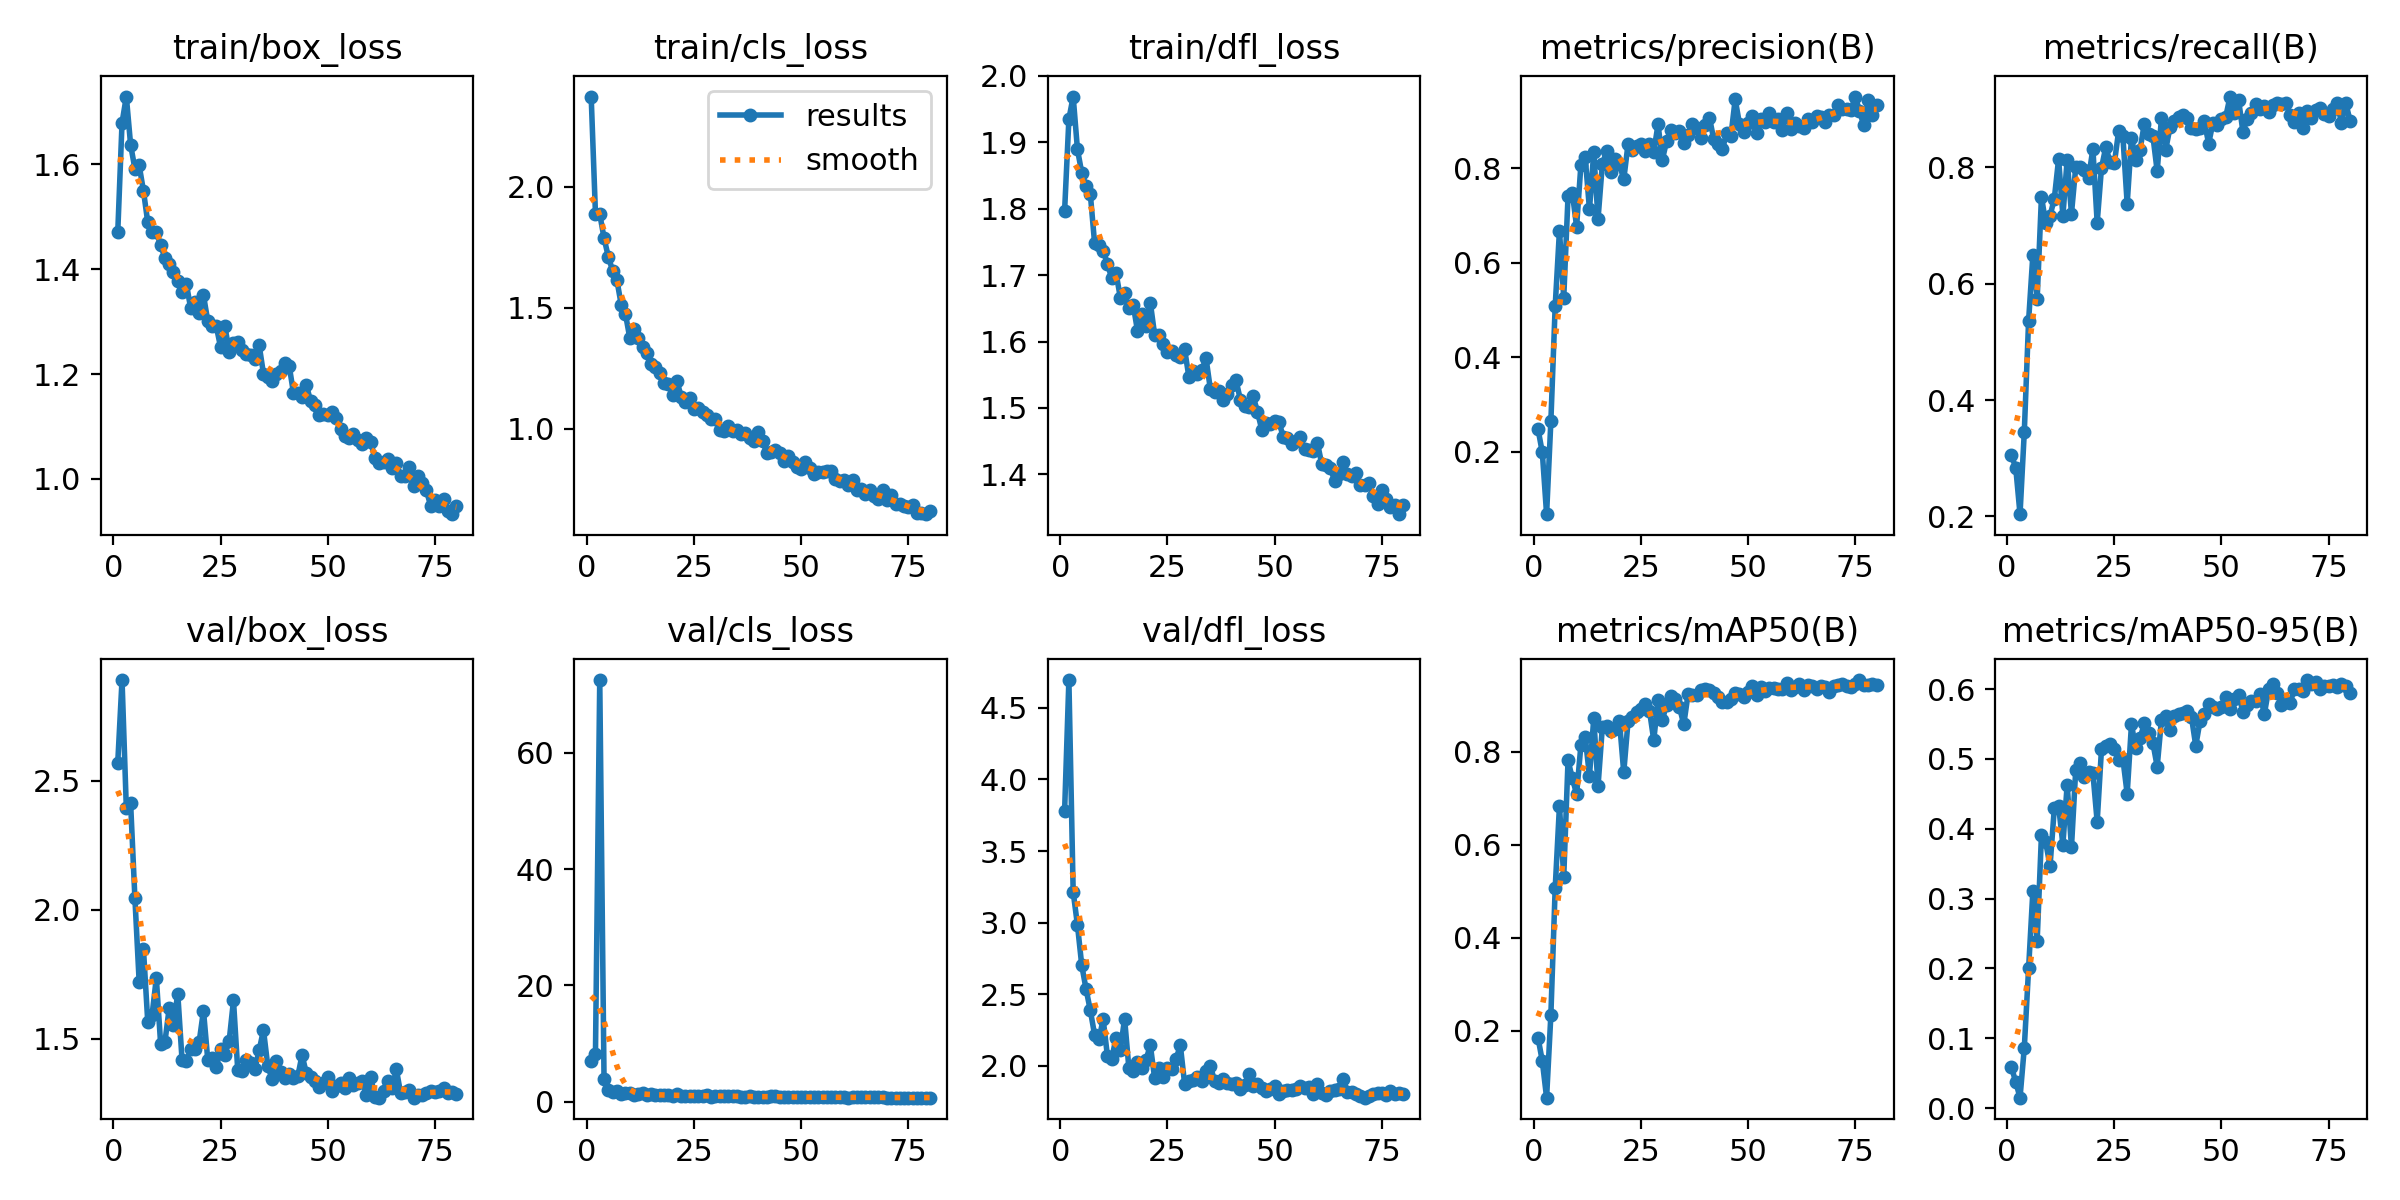

In [ ]:
Image(filename='/content/drive/MyDrive/runs/detect/train/results.png', width=1000)

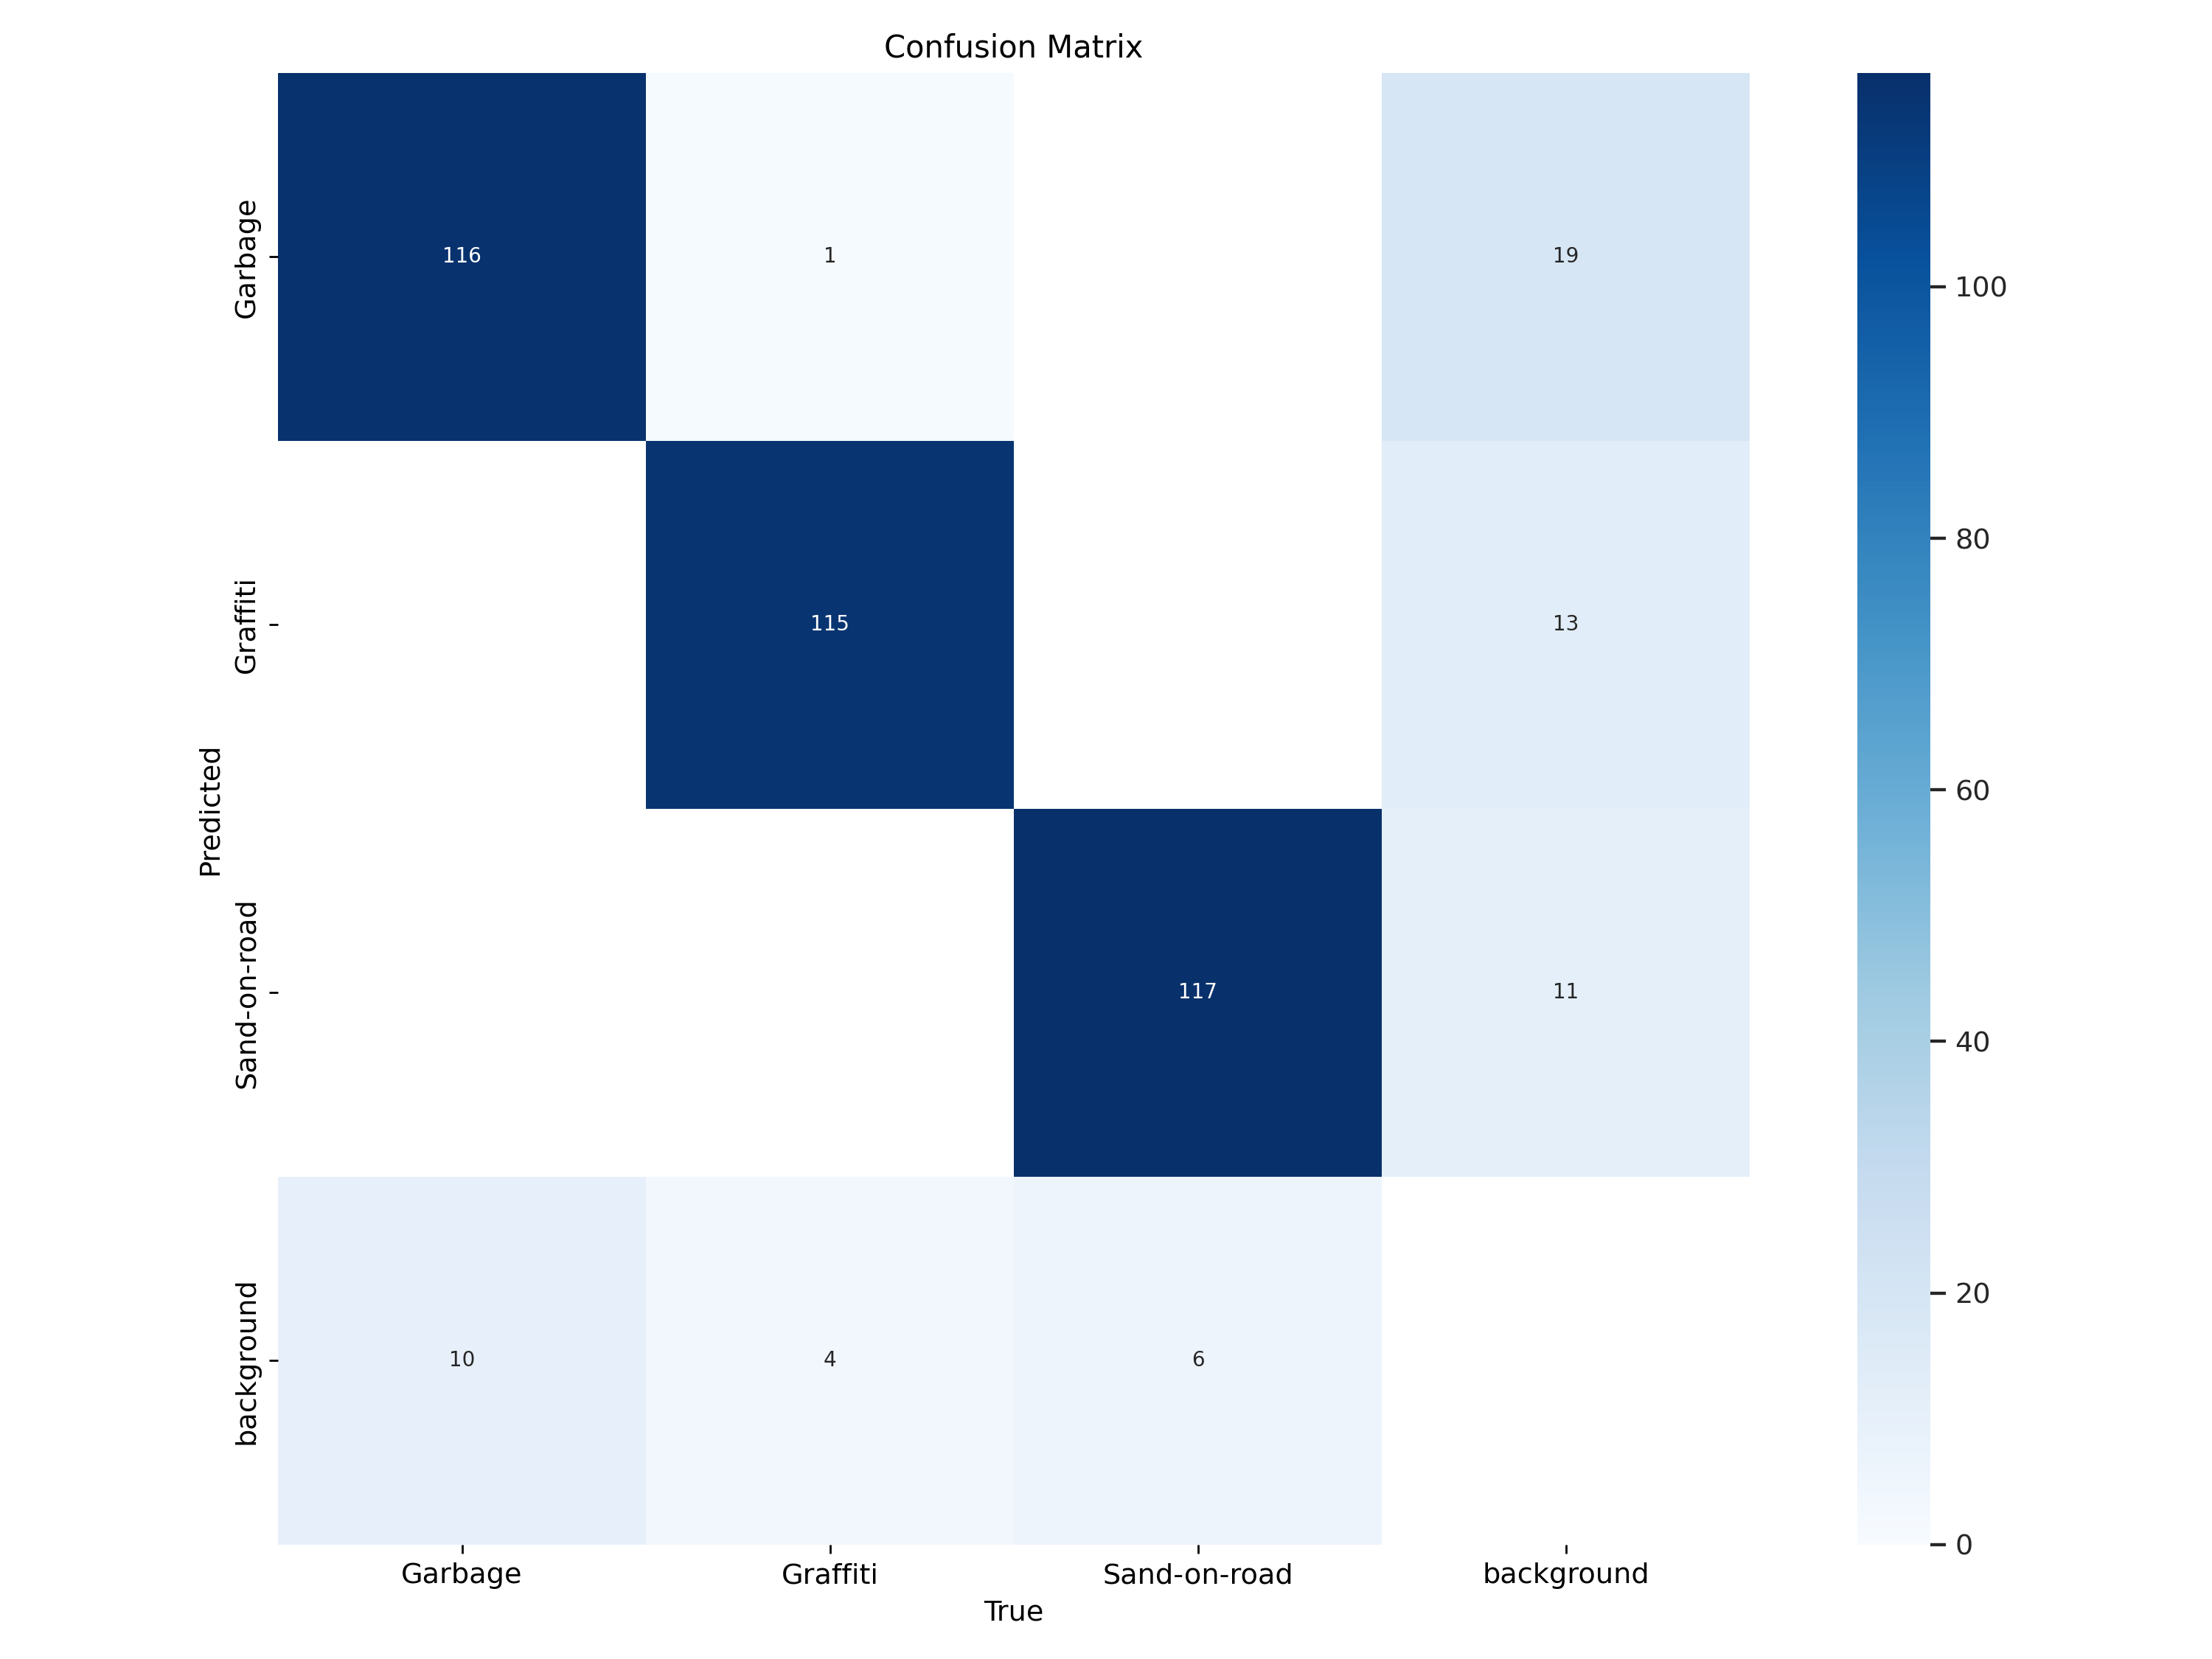

In [ ]:
Image(filename='/content/drive/MyDrive/runs/detect/train/confusion_matrix.png', width=1000)

Validation

In [ ]:
yolo_m_custom = YOLO('/content/drive/MyDrive/runs/detect/train/weights/best.pt')
val = yolo_m_custom.val()

Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:03<00:00,  6.74it/s]


                   all        360        369      0.913      0.898      0.942      0.612
               Garbage        120        126       0.91      0.889      0.903      0.545
              Graffiti        120        120      0.905      0.925      0.969       0.68
          Sand-on-road        120        123      0.923       0.88      0.955      0.612
Speed: 0.1ms preprocess, 4.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val


Testing

In [ ]:
test = yolo_m_custom.val(data='/content/data.yaml', split='test')

Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)


val: Scanning /content/test/labels... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<00:00, 1192.78it/s]

val: New cache created: /content/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:03<00:00,  6.57it/s]


                   all        360        368      0.898      0.891      0.926      0.572
               Garbage        120        123      0.916      0.883      0.909      0.542
              Graffiti        120        122      0.884       0.91      0.907      0.574
          Sand-on-road        120        123      0.893       0.88      0.962      0.599
Speed: 0.2ms preprocess, 3.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val2


#**ResNetYOLOv8_m**

In [ ]:
yolo_res = YOLO('/content/yolov8m.yaml').load('yolov8m.pt')
yolo_res.info()

Transferred 6/571 items from pretrained weights
YOLOv8m summary: 386 layers, 114,726,784 parameters, 114,726,768 gradients, 422.8 GFLOPs


(386, 114726784, 114726768, 422.81538559999996)

In [ ]:
print(yolo_res)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): ResNetLayer(
        (layer): Sequential(
          (0): Conv(
            (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
      )
      (1): ResNetLayer(
        (layer): Sequential(
          (0): ResNetBlock(
            (cv1): Conv(
              (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.00

Training

In [ ]:
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [16, 32]
patiences = [10, 15]
epochs_list = [100]

param_grid = list(itertools.product(learning_rates, batch_sizes, patiences, epochs_list))

weights_dir = "best_weights_G"
os.makedirs(weights_dir, exist_ok=True)

best_mAP = 0
best_params = None
best_weights_path = None

for lr, batch, patience, epochs in param_grid:
    print(f"Training with lr={lr}, batch={batch}, patience={patience}, epochs={epochs}")

    results = yolo_res.train(
        data='/content/data.yaml',
        epochs=epochs,
        imgsz=640,
        batch=batch,
        lr0=lr,
        patience=patience,
        cos_lr=True
    )

    current_mAP_50 = results.box.map50

    if current_mAP_50 > best_mAP:
        best_mAP = current_mAP_50
        best_params = (lr, batch, patience, epochs)
        best_weights_path = os.path.join(weights_dir, f"best_weights_lr{lr}_batch{batch}_epochs{epochs}_patience{patience}.pt")

        yolo_res.save(best_weights_path)

    print(f"Results for lr={lr}, batch={batch}, patience={patience}, epochs={epochs}: mAP={current_mAP_50:.4f}")

if best_params:
    print(f"Best mAP: {best_mAP:.4f} with parameters: lr={best_params[0]}, batch={best_params[1]}, patience={best_params[2]}, epochs={best_params[3]}")
    print(f"Best weights saved at: {best_weights_path}")
else:
    print("No successful training runs.")

Training with lr=0.001, batch=16, patience=10, epochs=100
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=yolov8m.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False,

100%|██████████| 755k/755k [00:00<00:00, 12.7MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1      9536  ultralytics.nn.modules.block.ResNetLayer     [3, 64, 1, True, 1]           
  1                  -1  1    215808  ultralytics.nn.modules.block.ResNetLayer     [64, 64, 1, False, 3]         
  2                  -1  1   1219584  ultralytics.nn.modules.block.ResNetLayer     [256, 128, 2, False, 4]       
  3                  -1  1   7098368  ultralytics.nn.modules.block.ResNetLayer     [512, 256, 2, False, 6]       
  4                  -1  1  14964736  ultralytics.nn.modules.block.ResNetLayer     [1024, 512, 2, False, 3]      
  5                  -1  1   4459648  ultralytics.nn.modules.block.SPPF            [2048, 576, 5]                
  6                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
  7             [-1, 3]  1         0  ultralytics.nn.modules.conv.Concat           [1] 

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.3MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<00:00, 1219.64it/s]

train: New cache created: /content/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/valid/labels... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<00:00, 1052.21it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 93 weight(decay=0.0), 100 weight(decay=0.0005), 99 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      16.4G      3.024      4.259      3.903         24        640: 100%|██████████| 68/68 [00:19<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


                   all        360        369   0.000201      0.181   0.000769   0.000161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      14.8G      2.667      3.539       3.33         26        640: 100%|██████████| 68/68 [00:17<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.20it/s]

                   all        360        369      0.499     0.0805    0.00428    0.00127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      15.2G       2.39       3.32      3.052         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.22it/s]

                   all        360        369      0.341     0.0278    0.00573    0.00116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      14.8G      2.194      3.051      2.865         22        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

                   all        360        369     0.0471      0.287     0.0275    0.00666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      14.8G      2.062      2.895      2.737         21        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.10it/s]

                   all        360        369     0.0881      0.217     0.0508      0.013



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      14.8G      2.012      2.844      2.652         14        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

                   all        360        369     0.0903     0.0981     0.0338     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      14.8G       1.92      2.729      2.578         16        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.24it/s]

                   all        360        369     0.0544      0.104     0.0348     0.0106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      14.8G      1.838      2.637      2.486         26        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.22it/s]

                   all        360        369      0.179      0.447      0.176     0.0576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      14.8G      1.812      2.593      2.473         23        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.29it/s]

                   all        360        369      0.219      0.412      0.184     0.0616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      14.8G      1.778       2.41      2.449         20        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.28it/s]

                   all        360        369      0.562      0.296      0.216     0.0826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      14.8G      1.755       2.43       2.44         18        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.19it/s]

                   all        360        369      0.279      0.256      0.206     0.0689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      14.8G      1.696      2.311      2.375         19        640: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.25it/s]

                   all        360        369        0.3      0.374      0.261      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      14.8G       1.68      2.267       2.33         14        640: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]

                   all        360        369      0.274        0.5      0.258     0.0815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      14.8G      1.676      2.226      2.328         20        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.28it/s]

                   all        360        369      0.358      0.432      0.366      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      14.8G      1.669      2.194      2.321         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.28it/s]

                   all        360        369      0.318      0.502      0.334      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      14.8G      1.648      2.179      2.278         17        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.24it/s]

                   all        360        369      0.414      0.554      0.409      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      14.8G      1.644      2.105      2.277         17        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]

                   all        360        369      0.221      0.263      0.173     0.0596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      14.8G      1.615      2.014      2.259         23        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

                   all        360        369      0.441      0.521      0.406      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      14.8G      1.609      2.018      2.244         20        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.20it/s]

                   all        360        369      0.434      0.498      0.444      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      14.8G      1.583      1.941      2.218         18        640: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.25it/s]

                   all        360        369      0.465      0.555      0.521      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      14.8G      1.609      2.016      2.236         20        640: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

                   all        360        369      0.476      0.539      0.484       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      14.8G      1.574      1.926      2.188         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

                   all        360        369      0.524      0.562      0.536       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      14.8G      1.574      1.879      2.194         21        640: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

                   all        360        369      0.587      0.581      0.568       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      14.8G       1.54      1.844       2.18         15        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

                   all        360        369      0.567      0.566      0.567      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      14.8G      1.529      1.825      2.161         21        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

                   all        360        369      0.632      0.615      0.629      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      14.8G      1.581      1.807      2.202         17        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]

                   all        360        369      0.589       0.54      0.563      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      14.8G       1.52      1.755      2.159         14        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.19it/s]

                   all        360        369      0.551      0.599      0.525      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      14.8G      1.539       1.74      2.171         16        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]

                   all        360        369      0.657      0.569      0.601      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      14.8G      1.542      1.711      2.154         18        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

                   all        360        369      0.454      0.595      0.491      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      14.8G      1.515      1.703      2.094         18        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]

                   all        360        369      0.563      0.604      0.572      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      14.8G      1.523      1.659      2.145         23        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]

                   all        360        369      0.618      0.692      0.682      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      14.8G      1.502      1.633      2.133         23        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.26it/s]

                   all        360        369      0.632      0.679      0.691      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      14.8G       1.48      1.653      2.108         22        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.26it/s]

                   all        360        369        0.7      0.725      0.729       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      14.8G      1.493      1.587      2.115         16        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

                   all        360        369      0.576      0.579      0.588      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      14.8G      1.448      1.567      2.076         21        640: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

                   all        360        369      0.706      0.673      0.715       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      14.8G      1.429      1.569       2.06         13        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.28it/s]

                   all        360        369      0.772      0.699      0.761      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      14.8G      1.453      1.593      2.069         11        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]

                   all        360        369      0.743      0.685      0.743      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      14.8G      1.441      1.524      2.055         23        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

                   all        360        369      0.795       0.75      0.807       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      14.8G      1.434      1.527      2.041         23        640: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]

                   all        360        369      0.742      0.702      0.743      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      14.8G      1.436      1.535      2.076         19        640: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

                   all        360        369      0.709      0.687      0.733      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      14.8G      1.447      1.509       2.06         18        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

                   all        360        369      0.657      0.714      0.704      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      14.8G      1.387      1.436      2.006         18        640: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

                   all        360        369      0.767      0.806      0.841       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      14.8G      1.381      1.415      2.004         14        640: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]

                   all        360        369      0.786      0.703      0.808      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      14.8G      1.371      1.415      1.989         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.28it/s]

                   all        360        369      0.666      0.702      0.747      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      14.8G      1.394       1.42      2.017         16        640: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

                   all        360        369      0.636      0.672      0.705      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      14.8G      1.377      1.381      2.005         22        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]

                   all        360        369      0.787      0.721      0.784      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      14.8G      1.377      1.395      1.974         18        640: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]

                   all        360        369      0.818      0.776      0.835      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      14.8G      1.367      1.379      1.988         25        640: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]

                   all        360        369      0.827      0.789      0.845       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      14.8G      1.365      1.358       1.97         20        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

                   all        360        369      0.787       0.75      0.807      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      14.8G      1.344      1.345       1.98         26        640: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.23it/s]

                   all        360        369      0.805      0.723      0.792      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      14.8G      1.344      1.344      1.967         19        640: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]

                   all        360        369      0.806      0.734      0.808      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      14.8G       1.34      1.336      1.964         17        640: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

                   all        360        369      0.791      0.717      0.786      0.429
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 42, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



52 epochs completed in 0.331 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 229.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 229.5MB

Validating runs/detect/train/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 293 layers, 114,477,977 parameters, 0 gradients, 420.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]


                   all        360        369      0.769      0.808      0.841       0.47
               Garbage        120        126      0.839      0.746      0.837      0.436
              Graffiti        120        120      0.721      0.882      0.846      0.483
          Sand-on-road        120        123      0.747      0.797      0.841      0.491
Speed: 0.1ms preprocess, 4.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train
Results for lr=0.001, batch=16, patience=10, epochs=100: mAP=0.8412
Training with lr=0.001, batch=16, patience=15, epochs=100
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=yolov8m.pt, optimizer=auto, verbose=

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 93 weight(decay=0.0), 100 weight(decay=0.0005), 99 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      16.3G      1.356      1.403      1.977         24        640: 100%|██████████| 68/68 [00:18<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.22it/s]

                   all        360        369      0.747      0.733       0.78      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      14.8G      1.391      1.422      2.024         26        640: 100%|██████████| 68/68 [00:17<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]

                   all        360        369      0.753      0.638      0.734      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      15.3G      1.434      1.508      2.047         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

                   all        360        369      0.696      0.728      0.737      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      14.8G      1.428      1.496       2.06         22        640: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.34it/s]

                   all        360        369       0.77      0.739        0.8      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      14.8G      1.424      1.497      2.042         21        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

                   all        360        369       0.65      0.575      0.644       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      14.8G      1.455      1.529      2.058         14        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

                   all        360        369      0.788      0.696      0.795      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      14.8G      1.437      1.473      2.054         16        640: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.28it/s]

                   all        360        369      0.721      0.729      0.768      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      14.8G       1.43      1.485      2.021         26        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

                   all        360        369       0.79      0.717      0.762      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      14.8G      1.401      1.466      2.026         23        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

                   all        360        369      0.731      0.668      0.731      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      14.8G      1.393      1.385      2.008         20        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

                   all        360        369      0.729      0.711      0.749      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      14.8G      1.403      1.449      2.015         18        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

                   all        360        369      0.703      0.641      0.697      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      14.8G      1.402      1.439      2.021         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.37it/s]

                   all        360        369      0.719      0.735      0.793      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      14.8G       1.38      1.424      1.988         14        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.34it/s]

                   all        360        369      0.692      0.736      0.749      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      14.8G      1.398      1.403      2.007         20        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

                   all        360        369      0.801      0.731      0.821      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      14.8G      1.372       1.38      1.993         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

                   all        360        369      0.729      0.699      0.769      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      14.8G      1.362       1.37      1.977         17        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]

                   all        360        369      0.749       0.73      0.791      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      14.8G      1.374      1.384      1.984         17        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.34it/s]

                   all        360        369      0.809      0.765       0.83      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      14.8G      1.349      1.291      1.966         23        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.34it/s]

                   all        360        369      0.802      0.789      0.829      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      14.8G      1.376      1.351      1.991         20        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.34it/s]

                   all        360        369      0.794      0.707      0.784      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      14.8G      1.334       1.31      1.959         18        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.23it/s]

                   all        360        369      0.868      0.783      0.863      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      14.8G      1.379       1.36      1.994         20        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.20it/s]

                   all        360        369      0.785      0.716      0.784      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      14.8G      1.329      1.298      1.948         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]

                   all        360        369      0.771      0.815      0.845      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      14.8G      1.337      1.284      1.957         21        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

                   all        360        369      0.763      0.795      0.812      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      14.8G      1.325      1.315       1.96         15        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.17it/s]

                   all        360        369      0.827       0.79       0.85      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      14.8G       1.32      1.288      1.947         21        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.28it/s]

                   all        360        369       0.81      0.781      0.846      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      14.8G      1.332      1.311       1.95         17        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

                   all        360        369      0.648      0.591      0.648      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      14.8G      1.282      1.264      1.912         14        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]

                   all        360        369      0.815      0.749      0.796      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      14.8G      1.315       1.25      1.943         16        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]

                   all        360        369      0.846      0.779      0.853      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      14.8G      1.312      1.263      1.922         18        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.36it/s]

                   all        360        369      0.812      0.784      0.839       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      14.8G      1.305      1.263      1.893         18        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.36it/s]

                   all        360        369      0.724       0.71      0.748      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      14.8G      1.293      1.211      1.925         23        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.29it/s]

                   all        360        369      0.782      0.761       0.81      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      14.8G      1.305      1.179      1.935         23        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.29it/s]

                   all        360        369      0.829      0.803      0.852      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      14.8G      1.274      1.217      1.897         22        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

                   all        360        369      0.848      0.797      0.865      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      14.8G      1.284      1.193      1.913         16        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

                   all        360        369      0.881      0.804      0.881      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      14.8G      1.245      1.205      1.876         21        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]

                   all        360        369      0.827      0.817      0.854      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      14.8G      1.281      1.201      1.905         13        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

                   all        360        369      0.807      0.826      0.851      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      14.8G      1.253      1.216      1.876         11        640: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.40it/s]

                   all        360        369      0.823      0.804      0.854      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      14.8G      1.271      1.178      1.888         23        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.36it/s]

                   all        360        369      0.867      0.834      0.894      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      14.8G      1.271      1.163      1.876         23        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.22it/s]

                   all        360        369      0.801      0.807      0.848      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      14.8G      1.272       1.18      1.911         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.34it/s]

                   all        360        369      0.833        0.8      0.876       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      14.8G      1.259      1.175      1.884         18        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.34it/s]

                   all        360        369      0.848      0.808      0.871      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      14.8G      1.235      1.126      1.866         18        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]

                   all        360        369       0.84      0.794      0.871      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      14.8G      1.216      1.114      1.844         14        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]

                   all        360        369      0.846      0.837      0.893      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      14.8G      1.221      1.132      1.851         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.26it/s]

                   all        360        369      0.819      0.858      0.891      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      14.8G      1.264      1.135      1.897         16        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.36it/s]

                   all        360        369      0.781      0.738      0.804      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      14.8G       1.22      1.091      1.861         22        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.37it/s]

                   all        360        369      0.796      0.825      0.849      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      14.8G      1.218      1.108      1.835         18        640: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.38it/s]

                   all        360        369      0.882      0.855      0.903       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      14.8G      1.192      1.106       1.83         25        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.36it/s]

                   all        360        369      0.811      0.819      0.852      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      14.8G      1.212      1.117      1.837         20        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.23it/s]

                   all        360        369      0.858       0.83      0.895      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      14.8G      1.203      1.092      1.838         26        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.38it/s]

                   all        360        369      0.865       0.84      0.891      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      14.8G      1.204      1.099      1.839         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

                   all        360        369      0.858      0.837      0.892      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      14.8G      1.197      1.082       1.83         17        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.38it/s]

                   all        360        369      0.867      0.844      0.905       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      14.8G      1.174      1.049      1.812         16        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

                   all        360        369      0.823      0.837      0.878       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      14.8G      1.185      1.058      1.838         14        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]

                   all        360        369      0.822      0.794       0.86      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      14.8G      1.175      1.063      1.812         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]

                   all        360        369      0.877      0.819      0.894      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      14.8G      1.188      1.065      1.827         17        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]

                   all        360        369      0.876      0.848      0.901      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      14.8G      1.182      1.075      1.814         23        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]

                   all        360        369      0.864       0.84      0.901      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      14.8G      1.167      1.031      1.794         16        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.40it/s]

                   all        360        369      0.892      0.837      0.914      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      14.8G      1.156      1.027      1.791         16        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

                   all        360        369      0.865       0.84      0.896      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      14.8G      1.154      1.019      1.804         23        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

                   all        360        369      0.875      0.838      0.906      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      14.8G      1.144     0.9971      1.781         21        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.37it/s]

                   all        360        369      0.919      0.839      0.924      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      14.8G      1.131      1.017      1.774         23        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]

                   all        360        369      0.901      0.853      0.922      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      14.8G      1.134     0.9979      1.768         21        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.36it/s]

                   all        360        369      0.883      0.886      0.922       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      14.8G      1.136     0.9997      1.763         27        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

                   all        360        369      0.875      0.855      0.915      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      14.8G      1.132     0.9957       1.77         22        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.38it/s]

                   all        360        369      0.857      0.866      0.906      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      14.8G      1.146      1.003      1.772         14        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.28it/s]

                   all        360        369      0.882      0.859      0.912      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      14.8G      1.127     0.9901      1.772         20        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.37it/s]

                   all        360        369      0.865      0.864      0.911      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      14.8G       1.11     0.9597      1.759         22        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.38it/s]

                   all        360        369      0.881      0.869      0.922      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      14.8G      1.122     0.9982      1.765         16        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.37it/s]

                   all        360        369      0.873      0.848      0.907      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      14.8G      1.084     0.9619      1.733         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.29it/s]

                   all        360        369      0.936      0.853      0.936      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      14.8G      1.118     0.9741       1.76         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.37it/s]

                   all        360        369      0.905      0.881      0.926      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      14.8G      1.093     0.9408      1.745         16        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.40it/s]

                   all        360        369      0.886      0.868       0.92      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      14.8G      1.102     0.9514      1.742         15        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.37it/s]

                   all        360        369      0.894      0.891      0.913      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      14.8G      1.062     0.9377      1.708         21        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.37it/s]

                   all        360        369       0.89      0.886      0.924      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      14.8G      1.079     0.9397      1.736         16        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.40it/s]

                   all        360        369      0.869      0.896      0.932      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      14.8G      1.065     0.9232      1.715         17        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.38it/s]

                   all        360        369      0.913       0.87      0.933      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      14.8G      1.074     0.8981      1.721         18        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.38it/s]

                   all        360        369      0.904      0.892      0.943      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      14.8G      1.068     0.9208      1.732         18        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

                   all        360        369      0.926      0.853      0.927       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      14.8G      1.072     0.9101       1.72         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.34it/s]

                   all        360        369      0.913      0.897      0.943      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      14.8G      1.075     0.9117      1.718         14        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.36it/s]

                   all        360        369      0.915       0.87       0.93      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      14.8G      1.067     0.9185      1.716         16        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]

                   all        360        369      0.938       0.86      0.939      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      14.8G      1.047     0.9037      1.689         17        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

                   all        360        369      0.921      0.896      0.938      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      14.8G       1.07     0.9095      1.708         20        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.38it/s]

                   all        360        369      0.919      0.858      0.929      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      14.8G      1.054     0.8783        1.7         24        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.36it/s]

                   all        360        369      0.918      0.879      0.927      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      14.8G      1.048     0.8875      1.711         15        640: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]

                   all        360        369        0.9      0.853      0.925      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      14.8G      1.041     0.8922      1.684         14        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.40it/s]

                   all        360        369      0.905      0.873       0.93      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      14.8G       1.03     0.8757      1.685         18        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

                   all        360        369      0.928      0.858      0.928      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      14.8G       1.02     0.8749      1.664         18        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.40it/s]

                   all        360        369      0.906      0.881      0.929      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      14.8G      1.055     0.8889      1.711         17        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.40it/s]

                   all        360        369      0.918      0.881      0.935      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      14.8G      1.027      0.858      1.684         18        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.40it/s]

                   all        360        369      0.911      0.867      0.925      0.591


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      14.8G      0.952     0.7402      1.684          8        640: 100%|██████████| 68/68 [00:17<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.40it/s]

                   all        360        369      0.908       0.86      0.917       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      14.8G     0.9262     0.7038      1.661          8        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

                   all        360        369      0.922      0.854      0.922      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      14.8G     0.9151     0.6656      1.648          9        640: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.22it/s]

                   all        360        369      0.918      0.852      0.924      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      14.8G     0.9154      0.659       1.65          8        640: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.38it/s]

                   all        360        369      0.902      0.869      0.925      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      14.8G     0.9102     0.6475      1.652          8        640: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]

                   all        360        369      0.908       0.87      0.924      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      14.8G     0.9053     0.6508      1.629          8        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]

                   all        360        369      0.891      0.883      0.926      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      14.8G     0.8935     0.6604      1.626          8        640: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.24it/s]

                   all        360        369      0.899      0.875      0.925      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      14.8G     0.8955     0.6511      1.621          9        640: 100%|██████████| 68/68 [00:17<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.38it/s]

                   all        360        369      0.896       0.88      0.927      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      14.8G     0.8944     0.6416      1.628          8        640: 100%|██████████| 68/68 [00:17<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.39it/s]

                   all        360        369      0.904      0.883      0.928      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      14.8G     0.9037     0.6362      1.647          8        640: 100%|██████████| 68/68 [00:16<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.41it/s]

                   all        360        369       0.91      0.877      0.929       0.59



100 epochs completed in 0.632 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 229.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 229.5MB

Validating runs/detect/train2/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 293 layers, 114,477,977 parameters, 0 gradients, 420.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.51it/s]


                   all        360        369      0.911      0.867      0.925      0.592
               Garbage        120        126      0.872      0.833      0.883      0.533
              Graffiti        120        120      0.932      0.914      0.953      0.654
          Sand-on-road        120        123      0.929      0.854       0.94      0.588
Speed: 0.1ms preprocess, 4.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train2
Results for lr=0.001, batch=16, patience=15, epochs=100: mAP=0.9252
Training with lr=0.001, batch=32, patience=10, epochs=100
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train22, exist_ok=False, pretrained=yolov8m.pt, optimizer=auto, verbos

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 93 weight(decay=0.0), 100 weight(decay=0.0005), 99 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train22
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      27.6G      1.039     0.8554      1.694         60        640: 100%|██████████| 34/34 [00:16<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        360        369      0.885      0.878      0.921      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      27.4G      1.147      0.966      1.781         55        640: 100%|██████████| 34/34 [00:16<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.744      0.747        0.8      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      27.8G      1.183      1.035      1.804         51        640: 100%|██████████| 34/34 [00:15<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        360        369      0.842      0.817      0.885       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      27.8G      1.197       1.03      1.834         64        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369       0.81      0.761      0.839       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      27.8G      1.208      1.056      1.848         52        640: 100%|██████████| 34/34 [00:15<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.843      0.756       0.85      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      27.8G      1.212      1.077      1.827         63        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369       0.82      0.744      0.818      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      27.8G      1.187       1.05      1.823         49        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.816      0.807      0.851      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      27.8G      1.226      1.076      1.845         54        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.871      0.836      0.897      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      27.8G      1.229      1.072      1.861         45        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.867      0.872      0.899      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      27.8G      1.178      1.027      1.809         53        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        360        369      0.866      0.809      0.868      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      27.8G      1.214      1.044      1.855         60        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.795      0.786      0.864      0.463
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



11 epochs completed in 0.083 hours.
Optimizer stripped from runs/detect/train22/weights/last.pt, 229.5MB
Optimizer stripped from runs/detect/train22/weights/best.pt, 229.5MB

Validating runs/detect/train22/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 293 layers, 114,477,977 parameters, 0 gradients, 420.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]


                   all        360        369      0.885      0.881      0.921      0.568
               Garbage        120        126      0.897      0.895      0.897      0.512
              Graffiti        120        120      0.901      0.925      0.947      0.638
          Sand-on-road        120        123      0.856      0.822      0.919      0.554
Speed: 0.1ms preprocess, 4.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train22
Results for lr=0.001, batch=32, patience=10, epochs=100: mAP=0.9210
Training with lr=0.001, batch=32, patience=15, epochs=100
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=15, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train222, exist_ok=False, pretrained=yolov8m.pt, optimizer=auto, verb

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 93 weight(decay=0.0), 100 weight(decay=0.0005), 99 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train222
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      27.5G     0.9569     0.7944      1.626         60        640: 100%|██████████| 34/34 [01:17<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]

                   all        360        369      0.908      0.859      0.914      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      27.4G      1.149     0.9679      1.785         55        640: 100%|██████████| 34/34 [00:16<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.749      0.755      0.826      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      27.8G      1.174      1.014      1.798         51        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        360        369      0.746      0.775      0.813      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      27.8G        1.2      1.045      1.838         64        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.812        0.8      0.868      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      27.8G      1.227      1.054      1.868         52        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.862      0.786      0.849      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      27.8G      1.215      1.077      1.835         63        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.799      0.731      0.799      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      27.8G      1.184       1.04      1.819         49        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369       0.78       0.78      0.844      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      27.8G      1.229      1.074      1.843         54        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        360        369      0.867      0.784      0.871      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      27.8G      1.218      1.074      1.864         45        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.837      0.859      0.899      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      27.8G      1.201      1.039      1.823         53        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.816      0.794      0.846      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      27.8G      1.221      1.051      1.864         60        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.845      0.768      0.872      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      27.8G        1.2      1.042      1.842         59        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.818      0.755      0.828      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      27.8G      1.207      1.046      1.833         55        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        360        369      0.858      0.797      0.859      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      27.8G      1.175      1.017      1.806         58        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        360        369      0.849      0.821      0.879      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      27.8G      1.185      1.011       1.82         58        640: 100%|██████████| 34/34 [00:15<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        360        369      0.887      0.819      0.874      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      27.8G      1.198      1.021      1.828         62        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.832      0.808      0.865      0.495
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



16 epochs completed in 0.113 hours.
Optimizer stripped from runs/detect/train222/weights/last.pt, 229.5MB
Optimizer stripped from runs/detect/train222/weights/best.pt, 229.5MB

Validating runs/detect/train222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 293 layers, 114,477,977 parameters, 0 gradients, 420.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]


                   all        360        369      0.908      0.859      0.914      0.567
               Garbage        120        126      0.905      0.873      0.908      0.527
              Graffiti        120        120      0.912        0.9      0.941      0.641
          Sand-on-road        120        123      0.908      0.805      0.894      0.533
Speed: 0.1ms preprocess, 4.2ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train222
Results for lr=0.001, batch=32, patience=15, epochs=100: mAP=0.9145
Training with lr=0.0005, batch=16, patience=10, epochs=100
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2222, exist_ok=False, pretrained=yolov8m.pt, optimizer=auto, v

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 93 weight(decay=0.0), 100 weight(decay=0.0005), 99 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2222
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      15.1G      1.054     0.8906      1.703         24        640: 100%|██████████| 68/68 [01:19<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.38it/s]

                   all        360        369      0.869      0.842      0.901      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      14.8G       1.14     0.9417      1.784         26        640: 100%|██████████| 68/68 [00:17<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

                   all        360        369      0.829       0.82      0.882      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      15.3G      1.214      1.046      1.834         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

                   all        360        369      0.791      0.787      0.836      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      14.8G      1.208      1.077      1.839         22        640: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.36it/s]

                   all        360        369      0.759      0.727      0.767      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      14.8G      1.214      1.068       1.85         21        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]

                   all        360        369      0.865       0.79      0.866      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      14.8G      1.249      1.118       1.85         14        640: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.24it/s]

                   all        360        369      0.826      0.833      0.888      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      14.8G      1.223      1.068      1.853         16        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

                   all        360        369      0.838       0.81      0.854      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      14.8G       1.21      1.103      1.823         26        640: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]

                   all        360        369      0.833      0.766      0.837      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      14.8G      1.206      1.098      1.844         23        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.29it/s]

                   all        360        369      0.838      0.843      0.878      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      14.8G      1.205       1.06      1.829         20        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

                   all        360        369      0.827       0.81      0.854      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      14.8G      1.188      1.098      1.824         18        640: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]

                   all        360        369      0.863      0.797       0.87      0.507
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



11 epochs completed in 0.088 hours.
Optimizer stripped from runs/detect/train2222/weights/last.pt, 229.5MB
Optimizer stripped from runs/detect/train2222/weights/best.pt, 229.5MB

Validating runs/detect/train2222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 293 layers, 114,477,977 parameters, 0 gradients, 420.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.44it/s]


                   all        360        369      0.869      0.842      0.901      0.545
               Garbage        120        126      0.841      0.833      0.862      0.507
              Graffiti        120        120      0.908      0.858        0.9      0.573
          Sand-on-road        120        123      0.858      0.834       0.94      0.555
Speed: 0.1ms preprocess, 4.6ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train2222
Results for lr=0.0005, batch=16, patience=10, epochs=100: mAP=0.9008
Training with lr=0.0005, batch=16, patience=15, epochs=100
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train22222, exist_ok=False, pretrained=yolov8m.pt, optimizer=auto

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train22222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 93 weight(decay=0.0), 100 weight(decay=0.0005), 99 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train22222
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      15.7G     0.9375     0.8187      1.611         24        640: 100%|██████████| 68/68 [01:19<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.28it/s]

                   all        360        369      0.891      0.828      0.908      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      14.8G      1.147     0.9412      1.791         26        640: 100%|██████████| 68/68 [00:17<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.37it/s]

                   all        360        369      0.828      0.796      0.867      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      15.2G      1.217      1.047      1.841         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

                   all        360        369      0.795      0.756       0.81       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      14.8G      1.208      1.082      1.845         22        640: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.29it/s]

                   all        360        369      0.839      0.778      0.867      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      14.8G       1.22      1.077      1.858         21        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

                   all        360        369      0.785      0.773      0.811      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      14.8G      1.229      1.106      1.842         14        640: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.34it/s]

                   all        360        369      0.841      0.801      0.876      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      14.8G      1.207      1.062      1.845         16        640: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

                   all        360        369      0.877      0.801      0.869      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      14.8G      1.223      1.098      1.829         26        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

                   all        360        369      0.846      0.827      0.877      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      14.8G       1.22      1.086      1.864         23        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.29it/s]

                   all        360        369      0.805      0.767      0.816      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      14.8G      1.208       1.05      1.839         20        640: 100%|██████████| 68/68 [00:17<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.34it/s]

                   all        360        369      0.864      0.805      0.881      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      14.8G      1.195      1.082      1.827         18        640: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]

                   all        360        369      0.832      0.823      0.869      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      14.8G      1.219       1.11      1.855         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.36it/s]

                   all        360        369      0.825      0.795      0.869      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      14.8G      1.191      1.061      1.817         14        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

                   all        360        369      0.843      0.835      0.867      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      14.8G      1.192      1.046      1.818         20        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.29it/s]

                   all        360        369      0.869      0.829      0.885      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      14.8G      1.191      1.042      1.824         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.29it/s]

                   all        360        369      0.826      0.783      0.859      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      14.8G      1.181      1.057       1.81         17        640: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

                   all        360        369      0.819      0.814      0.876      0.508
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



16 epochs completed in 0.119 hours.
Optimizer stripped from runs/detect/train22222/weights/last.pt, 229.5MB
Optimizer stripped from runs/detect/train22222/weights/best.pt, 229.5MB

Validating runs/detect/train22222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 293 layers, 114,477,977 parameters, 0 gradients, 420.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.55it/s]


                   all        360        369      0.891      0.828      0.908      0.556
               Garbage        120        126      0.909      0.792      0.871       0.51
              Graffiti        120        120      0.888      0.862      0.919      0.597
          Sand-on-road        120        123      0.876      0.829      0.935      0.561
Speed: 0.1ms preprocess, 4.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train22222
Results for lr=0.0005, batch=16, patience=15, epochs=100: mAP=0.9083
Training with lr=0.0005, batch=32, patience=10, epochs=100
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train222222, exist_ok=False, pretrained=yolov8m.pt, optimizer=au

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train222222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 93 weight(decay=0.0), 100 weight(decay=0.0005), 99 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train222222
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      27.5G     0.8984     0.7566       1.58         60        640: 100%|██████████| 34/34 [01:17<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.879      0.878      0.911      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      27.4G      1.163     0.9657      1.802         55        640: 100%|██████████| 34/34 [00:16<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.755      0.776      0.813      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      27.8G      1.186      1.031       1.81         51        640: 100%|██████████| 34/34 [00:15<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        360        369      0.768      0.776      0.819      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      27.8G      1.191      1.049      1.835         64        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.824      0.738       0.81      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      27.8G      1.217      1.026      1.858         52        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        360        369      0.843      0.843      0.881      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      27.8G      1.212      1.079      1.831         63        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        360        369      0.779      0.789      0.833      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      27.8G      1.192      1.055      1.826         49        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        360        369      0.738      0.759      0.778      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      27.8G      1.231      1.087      1.853         54        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        360        369       0.83      0.748      0.806      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      27.8G      1.223      1.081      1.862         45        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        360        369      0.801      0.862      0.874      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      27.8G      1.203      1.046      1.828         53        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        360        369      0.785      0.703      0.781      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      27.8G      1.216       1.05      1.858         60        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369       0.82      0.792      0.862      0.472
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



11 epochs completed in 0.084 hours.
Optimizer stripped from runs/detect/train222222/weights/last.pt, 229.5MB
Optimizer stripped from runs/detect/train222222/weights/best.pt, 229.5MB

Validating runs/detect/train222222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 293 layers, 114,477,977 parameters, 0 gradients, 420.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.98it/s]


                   all        360        369      0.879      0.878      0.911      0.556
               Garbage        120        126      0.849      0.881      0.888      0.516
              Graffiti        120        120      0.899      0.908      0.941      0.607
          Sand-on-road        120        123      0.889      0.844      0.905      0.544
Speed: 0.1ms preprocess, 4.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train222222
Results for lr=0.0005, batch=32, patience=10, epochs=100: mAP=0.9112
Training with lr=0.0005, batch=32, patience=15, epochs=100
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=15, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2222222, exist_ok=False, pretrained=yolov8m.pt, optimizer=

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2222222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 93 weight(decay=0.0), 100 weight(decay=0.0005), 99 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2222222
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      27.6G     0.8169     0.6868      1.515         60        640: 100%|██████████| 34/34 [01:17<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.886      0.864      0.911      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      27.4G      1.158     0.9612      1.798         55        640: 100%|██████████| 34/34 [00:16<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.806      0.761       0.82      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      27.8G      1.181      1.028      1.813         51        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        360        369      0.733      0.783      0.778       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      27.8G      1.196      1.029      1.836         64        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.796      0.787      0.841      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      27.9G       1.22      1.039      1.867         52        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.815      0.806      0.854      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      27.8G      1.213      1.078      1.838         63        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.807      0.792       0.81      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      27.8G      1.188      1.045      1.831         49        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        360        369      0.857      0.814       0.88      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      27.8G      1.218      1.068      1.841         54        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.874      0.812      0.881      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      27.8G      1.223       1.05      1.865         45        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.813      0.802      0.869      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      27.9G        1.2      1.024      1.825         53        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369       0.91      0.778      0.887      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      27.8G       1.22      1.061      1.872         60        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        360        369       0.88       0.77      0.877      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      27.8G      1.212      1.051      1.855         59        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.823      0.811      0.877       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      27.8G      1.193      1.035      1.823         55        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.869      0.802      0.859      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      27.9G      1.172      1.013      1.804         58        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.723      0.713      0.748      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      27.8G      1.186      1.013      1.817         58        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.869      0.818      0.871      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      27.9G      1.188      1.013      1.818         62        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.835      0.836      0.886      0.517
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



16 epochs completed in 0.113 hours.
Optimizer stripped from runs/detect/train2222222/weights/last.pt, 229.5MB
Optimizer stripped from runs/detect/train2222222/weights/best.pt, 229.5MB

Validating runs/detect/train2222222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 293 layers, 114,477,977 parameters, 0 gradients, 420.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]


                   all        360        369      0.886      0.864      0.911      0.558
               Garbage        120        126      0.894      0.872      0.908      0.513
              Graffiti        120        120      0.887      0.912      0.932      0.631
          Sand-on-road        120        123      0.877      0.808      0.893      0.529
Speed: 0.1ms preprocess, 4.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train2222222
Results for lr=0.0005, batch=32, patience=15, epochs=100: mAP=0.9109
Training with lr=0.0001, batch=16, patience=10, epochs=100
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train22222222, exist_ok=False, pretrained=yolov8m.pt, optimize

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train22222222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 93 weight(decay=0.0), 100 weight(decay=0.0005), 99 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train22222222
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100        16G     0.8864     0.7539       1.57         24        640: 100%|██████████| 68/68 [00:18<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [01:03<00:00,  5.29s/it]

                   all        360        369      0.903       0.83      0.899      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      14.8G      1.161     0.9405      1.807         26        640: 100%|██████████| 68/68 [00:17<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

                   all        360        369       0.74      0.739      0.775      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      15.3G      1.221      1.057       1.84         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

                   all        360        369       0.73      0.781      0.772      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      14.8G      1.208      1.088      1.846         22        640: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

                   all        360        369      0.833      0.807      0.867      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      14.8G      1.222      1.085      1.858         21        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

                   all        360        369      0.818      0.762      0.838      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      14.8G      1.235      1.106      1.838         14        640: 100%|██████████| 68/68 [00:17<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

                   all        360        369       0.89      0.818      0.886      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      14.8G      1.219      1.071      1.856         16        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.34it/s]

                   all        360        369      0.831      0.785      0.858       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      14.8G      1.221      1.103      1.828         26        640: 100%|██████████| 68/68 [00:17<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.29it/s]

                   all        360        369      0.842      0.837      0.876      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      14.8G      1.213      1.099      1.852         23        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

                   all        360        369      0.883      0.838      0.888      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      14.8G      1.198      1.046      1.824         20        640: 100%|██████████| 68/68 [00:17<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

                   all        360        369      0.841      0.846      0.892      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      14.8G      1.189      1.075      1.829         18        640: 100%|██████████| 68/68 [00:17<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.34it/s]

                   all        360        369      0.845      0.845      0.886      0.512
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



11 epochs completed in 0.088 hours.
Optimizer stripped from runs/detect/train22222222/weights/last.pt, 229.5MB
Optimizer stripped from runs/detect/train22222222/weights/best.pt, 229.5MB

Validating runs/detect/train22222222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 293 layers, 114,477,977 parameters, 0 gradients, 420.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]


                   all        360        369      0.901      0.831      0.899      0.547
               Garbage        120        126      0.879      0.817      0.857      0.495
              Graffiti        120        120      0.895      0.854      0.923      0.603
          Sand-on-road        120        123      0.927      0.821      0.916      0.542
Speed: 0.1ms preprocess, 4.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train22222222
Results for lr=0.0001, batch=16, patience=10, epochs=100: mAP=0.8988
Training with lr=0.0001, batch=16, patience=15, epochs=100
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train222222222, exist_ok=False, pretrained=yolov8m.pt, optimi

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train222222222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 93 weight(decay=0.0), 100 weight(decay=0.0005), 99 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train222222222
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100        16G     0.7998     0.6957      1.496         24        640: 100%|██████████| 68/68 [01:19<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.36it/s]

                   all        360        369      0.842      0.852        0.9      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      14.8G      1.176     0.9519      1.821         26        640: 100%|██████████| 68/68 [00:17<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.28it/s]

                   all        360        369       0.78      0.823       0.85      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      14.9G      1.225      1.064      1.851         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.29it/s]

                   all        360        369      0.793      0.786      0.824      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      14.8G      1.214      1.091      1.855         22        640: 100%|██████████| 68/68 [00:17<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]

                   all        360        369      0.808       0.78      0.841      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      14.8G       1.22      1.074      1.862         21        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

                   all        360        369      0.776      0.676       0.76      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      14.8G      1.227       1.11      1.841         14        640: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.28it/s]

                   all        360        369      0.849      0.786      0.867      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      14.8G      1.219      1.089      1.859         16        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

                   all        360        369      0.815      0.825      0.885      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      14.8G      1.205      1.096      1.819         26        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

                   all        360        369       0.87      0.778      0.876      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      14.8G      1.199      1.067      1.841         23        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.30it/s]

                   all        360        369      0.832      0.838      0.882      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      14.8G      1.193      1.048      1.822         20        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

                   all        360        369      0.837      0.745      0.841      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      14.8G       1.19       1.07      1.828         18        640: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

                   all        360        369      0.868      0.734      0.854      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      14.8G      1.196      1.085      1.841         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]

                   all        360        369      0.902      0.791      0.875      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      14.8G      1.178      1.066      1.805         14        640: 100%|██████████| 68/68 [00:17<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.26it/s]

                   all        360        369      0.804      0.773      0.824       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      14.8G      1.192      1.041      1.815         20        640: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

                   all        360        369      0.834      0.827      0.868      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      14.8G      1.198      1.061      1.824         19        640: 100%|██████████| 68/68 [00:17<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.36it/s]

                   all        360        369      0.858      0.848      0.894      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      14.8G      1.176      1.061      1.809         17        640: 100%|██████████| 68/68 [00:17<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.36it/s]

                   all        360        369      0.771      0.789      0.812       0.48
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



16 epochs completed in 0.120 hours.
Optimizer stripped from runs/detect/train222222222/weights/last.pt, 229.5MB
Optimizer stripped from runs/detect/train222222222/weights/best.pt, 229.5MB

Validating runs/detect/train222222222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 293 layers, 114,477,977 parameters, 0 gradients, 420.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.49it/s]


                   all        360        369      0.839      0.855        0.9      0.535
               Garbage        120        126       0.86      0.827      0.871      0.504
              Graffiti        120        120      0.828      0.908      0.945      0.585
          Sand-on-road        120        123      0.829      0.828      0.883      0.516
Speed: 0.1ms preprocess, 4.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train222222222
Results for lr=0.0001, batch=16, patience=15, epochs=100: mAP=0.8997
Training with lr=0.0001, batch=32, patience=10, epochs=100
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2222222222, exist_ok=False, pretrained=yolov8m.pt, opti

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2222222222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 93 weight(decay=0.0), 100 weight(decay=0.0005), 99 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2222222222
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      27.6G     0.8013     0.6668      1.495         60        640: 100%|██████████| 34/34 [00:16<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:03<00:00, 10.56s/it]

                   all        360        369      0.873      0.844       0.89      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      27.4G      1.182     0.9673      1.826         55        640: 100%|██████████| 34/34 [00:16<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.729      0.746      0.776      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      27.8G      1.203      1.033      1.831         51        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

                   all        360        369      0.669       0.74      0.726      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      27.9G      1.212       1.04      1.844         64        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        360        369      0.782      0.708       0.77      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      27.9G      1.226      1.041      1.863         52        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369       0.85      0.792      0.859      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      27.9G      1.203      1.077      1.827         63        640: 100%|██████████| 34/34 [00:16<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        360        369      0.809      0.749      0.815      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      27.9G      1.191      1.047      1.826         49        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.781       0.74      0.794      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      27.8G      1.224      1.058      1.839         54        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.848      0.854      0.881      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      27.9G      1.211      1.066      1.844         45        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.827      0.731      0.824       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      27.8G      1.175      1.025      1.807         53        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

                   all        360        369      0.834      0.754      0.862      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      27.9G      1.216      1.036      1.854         60        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        360        369      0.851      0.761      0.854      0.472
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



11 epochs completed in 0.084 hours.
Optimizer stripped from runs/detect/train2222222222/weights/last.pt, 229.5MB
Optimizer stripped from runs/detect/train2222222222/weights/best.pt, 229.5MB

Validating runs/detect/train2222222222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 293 layers, 114,477,977 parameters, 0 gradients, 420.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.85it/s]


                   all        360        369      0.873      0.844       0.89      0.528
               Garbage        120        126      0.839      0.873       0.89      0.507
              Graffiti        120        120      0.892      0.891      0.918      0.585
          Sand-on-road        120        123      0.887      0.767      0.863      0.491
Speed: 0.1ms preprocess, 4.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train2222222222
Results for lr=0.0001, batch=32, patience=10, epochs=100: mAP=0.8903
Training with lr=0.0001, batch=32, patience=15, epochs=100
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8m.yaml, data=/content/data.yaml, epochs=100, time=None, patience=15, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train22222222222, exist_ok=False, pretrained=yolov8m.pt, op

train: Scanning /content/train/labels.cache... 1080 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 1100. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]


Plotting labels to runs/detect/train22222222222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 93 weight(decay=0.0), 100 weight(decay=0.0005), 99 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train22222222222
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      27.6G     0.7349     0.6145      1.441         60        640: 100%|██████████| 34/34 [00:16<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [01:03<00:00, 10.56s/it]

                   all        360        369      0.845       0.85       0.88      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      27.4G      1.185     0.9852      1.828         55        640: 100%|██████████| 34/34 [00:16<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.741      0.836      0.806      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      27.8G      1.203      1.036      1.829         51        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.764      0.797      0.804       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      27.8G       1.21       1.04      1.854         64        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.848      0.798      0.865      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      27.8G      1.234      1.046      1.865         52        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.836      0.773      0.857       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      27.8G      1.199      1.054      1.819         63        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.823        0.8      0.838      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      27.8G      1.184      1.058      1.823         49        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369       0.74      0.785      0.802      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      27.8G      1.226      1.061      1.846         54        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.893      0.837      0.891      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      27.9G      1.222      1.052      1.864         45        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.865      0.859      0.892      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      27.8G      1.189      1.036      1.817         53        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.856      0.793      0.864        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      27.8G      1.222      1.054      1.867         60        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        360        369      0.794      0.718      0.811      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      27.8G      1.201      1.039      1.838         59        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        360        369      0.716      0.693      0.748      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      27.8G      1.192      1.022      1.814         55        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.843      0.801      0.846      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      27.8G       1.16      1.016      1.794         58        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.856      0.819      0.886      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      27.8G       1.19      1.017      1.815         58        640: 100%|██████████| 34/34 [00:15<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369       0.85      0.824      0.882      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      27.9G      1.187      1.005      1.814         62        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.829      0.828      0.864      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      27.8G      1.165      1.021      1.802         50        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        360        369      0.825      0.791      0.871      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      27.8G      1.183      1.043      1.819         52        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.808      0.835      0.875      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      27.8G        1.2      1.009       1.83         65        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.834      0.839       0.89       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      27.8G      1.167      1.029      1.804         57        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        360        369      0.867      0.835      0.878      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      27.8G      1.166      0.976      1.792         60        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        360        369      0.861      0.848      0.885      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      27.8G      1.169     0.9937      1.801         52        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.834      0.808       0.87      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      27.8G      1.172     0.9741       1.81         62        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.892      0.811      0.903      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      27.9G      1.155      1.013      1.785         60        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.799      0.764      0.839      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      27.8G      1.131     0.9707      1.766         56        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.888      0.846      0.905      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      27.8G      1.149     0.9661      1.791         52        640: 100%|██████████| 34/34 [00:15<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.811      0.867      0.898      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      27.8G      1.141     0.9799      1.783         44        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.861      0.831      0.899      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      27.8G       1.13     0.9452      1.776         49        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369       0.84      0.835      0.834      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      27.8G      1.132     0.9502      1.779         57        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        360        369      0.867      0.854      0.895      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      27.8G      1.133      0.961      1.771         60        640: 100%|██████████| 34/34 [00:15<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.793      0.813      0.866      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      27.8G      1.138     0.9417      1.775         59        640: 100%|██████████| 34/34 [00:15<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        360        369      0.876      0.839      0.904      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      27.8G      1.107      0.907      1.747         50        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.831      0.843      0.886      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      27.8G      1.123     0.9377      1.761         59        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.845      0.757      0.844      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      27.9G      1.116     0.9388      1.755         66        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.809      0.852      0.886      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      27.9G      1.106     0.9377      1.752         51        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.837      0.862      0.893      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      27.9G      1.118     0.9554      1.748         60        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.853      0.808      0.874      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      27.8G      1.115     0.9499      1.748         58        640: 100%|██████████| 34/34 [00:15<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        360        369      0.848      0.818      0.889      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      27.8G      1.077     0.8983      1.728         51        640: 100%|██████████| 34/34 [00:15<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]

                   all        360        369      0.875      0.847      0.903      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      27.9G      1.094     0.9038      1.735         60        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        360        369       0.84      0.766      0.845      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      27.8G      1.101      0.914      1.741         61        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.904      0.815      0.909      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      27.8G      1.077     0.8975      1.726         63        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.904      0.819      0.881      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      27.8G      1.065     0.8744      1.713         60        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.874      0.854       0.91      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      27.8G      1.075      0.903      1.713         59        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all        360        369      0.841      0.862      0.905      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      27.8G      1.075     0.9069      1.708         55        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.881      0.835      0.888      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      27.8G      1.083     0.8975      1.711         56        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.882      0.861      0.908      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      27.8G       1.05     0.8584        1.7         52        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.881      0.872      0.908      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      27.8G       1.04     0.8469      1.705         64        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.891      0.824      0.899      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      27.8G      1.039     0.8453      1.684         60        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.863      0.839      0.903      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      27.8G      1.034     0.8485      1.689         64        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all        360        369      0.899      0.867      0.921      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      27.8G      1.042     0.8483      1.705         65        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.895      0.854      0.925      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      27.8G      1.028     0.8481      1.677         56        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.897      0.851      0.924      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      27.8G      1.041     0.8525      1.679         58        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all        360        369      0.861      0.875       0.92      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      27.8G      1.008     0.8265      1.667         60        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.898      0.879      0.925      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      27.8G      1.003     0.8145      1.647         61        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        360        369      0.899      0.859      0.907      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      27.8G      1.002     0.8116      1.667         56        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        360        369       0.89      0.842      0.906      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      27.8G      1.004     0.8265      1.655         62        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.888      0.849      0.917       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      27.8G      1.003     0.8143      1.667         62        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.892      0.846       0.91      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      27.8G     0.9944     0.7898      1.648         72        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]

                   all        360        369      0.907      0.873      0.929       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      27.8G      1.017     0.8206      1.666         50        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.881      0.884      0.917      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      27.8G     0.9795      0.794      1.632         60        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        360        369      0.897      0.878      0.929      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      27.8G     0.9803     0.7768      1.626         51        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.915      0.889      0.924      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      27.8G     0.9878     0.7858      1.631         50        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.911      0.872      0.925      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      27.8G     0.9682     0.7628      1.622         51        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.901      0.878      0.928      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      27.9G     0.9436      0.748      1.601         64        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all        360        369      0.915      0.865      0.928      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      27.8G     0.9673     0.7702      1.629         52        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.888      0.859      0.912      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      27.8G     0.9416     0.7719       1.61         64        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.903      0.846      0.918      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      27.9G     0.9625     0.7717      1.604         48        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.916      0.892       0.93      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      27.8G     0.9506     0.7479      1.616         54        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.895      0.881      0.928      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      27.8G     0.9211      0.728       1.58         60        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.927      0.866      0.933      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      27.8G     0.9346     0.7453      1.594         53        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all        360        369      0.938      0.861      0.929      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      27.9G     0.9011     0.7363      1.569         63        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.918       0.88      0.935      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      27.8G     0.9381     0.7466      1.601         57        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.908      0.884      0.934      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      27.8G     0.9387     0.7512      1.608         60        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.914      0.874      0.932      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      27.8G     0.9118     0.7305       1.58         51        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.903      0.886      0.921      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      27.8G     0.9081     0.7303      1.576         58        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.887      0.894      0.929      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      27.8G     0.9139     0.7142      1.573         67        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.896      0.894       0.93      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      27.8G     0.9017     0.7028       1.57         59        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        360        369      0.919      0.874      0.932      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      27.9G     0.9114     0.7206      1.573         63        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.889      0.887      0.926      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      27.8G     0.8997     0.7256      1.573         52        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.913      0.891      0.931      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      27.9G     0.9138     0.7328      1.575         67        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.913      0.888      0.932      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      27.8G     0.8882     0.7187      1.552         54        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.896      0.898      0.935      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      27.8G     0.8916     0.7054      1.564         56        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all        360        369      0.937      0.864      0.937      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      27.9G     0.8846      0.697       1.55         57        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.916      0.881      0.934      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      27.8G     0.8894     0.6998      1.551         59        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

                   all        360        369      0.913      0.892      0.938      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      27.8G      0.871     0.6971      1.549         61        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369       0.91      0.884      0.937      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      27.8G     0.9136      0.704      1.579         67        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.905      0.887      0.928      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      27.8G     0.8688     0.6821      1.553         46        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.915      0.864       0.93      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      27.8G     0.8793     0.6798      1.542         61        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.892      0.884      0.929      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      27.8G     0.8751     0.6964      1.533         62        640: 100%|██████████| 34/34 [00:16<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all        360        369      0.896       0.89      0.932      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      27.8G     0.8745     0.6913      1.546         61        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369       0.91      0.897      0.932      0.606


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      27.8G     0.7479     0.5384      1.472         25        640: 100%|██████████| 34/34 [00:16<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        360        369      0.885      0.895      0.923      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      27.8G      0.735     0.5281      1.475         24        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

                   all        360        369      0.911      0.873      0.925      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      27.8G     0.6826     0.4817      1.413         26        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.909      0.864      0.923      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      27.8G     0.6952     0.4878      1.423         24        640: 100%|██████████| 34/34 [00:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

                   all        360        369      0.897      0.865      0.917      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      27.8G     0.6959     0.4781      1.426         24        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.902      0.885      0.925      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      27.8G     0.6824     0.4732      1.408         25        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.922      0.879      0.924      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      27.8G     0.6899     0.4654      1.421         24        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

                   all        360        369      0.904      0.876      0.921      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      27.8G     0.6856     0.4606      1.411         27        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

                   all        360        369      0.909      0.875      0.926      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      27.8G     0.6735     0.4628      1.388         25        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.903      0.884      0.926      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      27.8G      0.683     0.4643      1.404         24        640: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

                   all        360        369      0.907      0.889      0.924       0.59



100 epochs completed in 0.612 hours.
Optimizer stripped from runs/detect/train22222222222/weights/last.pt, 229.5MB
Optimizer stripped from runs/detect/train22222222222/weights/best.pt, 229.5MB

Validating runs/detect/train22222222222/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 293 layers, 114,477,977 parameters, 0 gradients, 420.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


                   all        360        369       0.91      0.897      0.932      0.606
               Garbage        120        126      0.909      0.881      0.911      0.581
              Graffiti        120        120      0.934      0.925      0.957      0.669
          Sand-on-road        120        123      0.886      0.884      0.927      0.567
Speed: 0.1ms preprocess, 4.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train22222222222
Results for lr=0.0001, batch=32, patience=15, epochs=100: mAP=0.9316
Best mAP: 0.9316 with parameters: lr=0.0001, batch=32, patience=15, epochs=100
Best weights saved at: best_weights_G/best_weights_lr0.0001_batch32_epochs100_patience15.pt


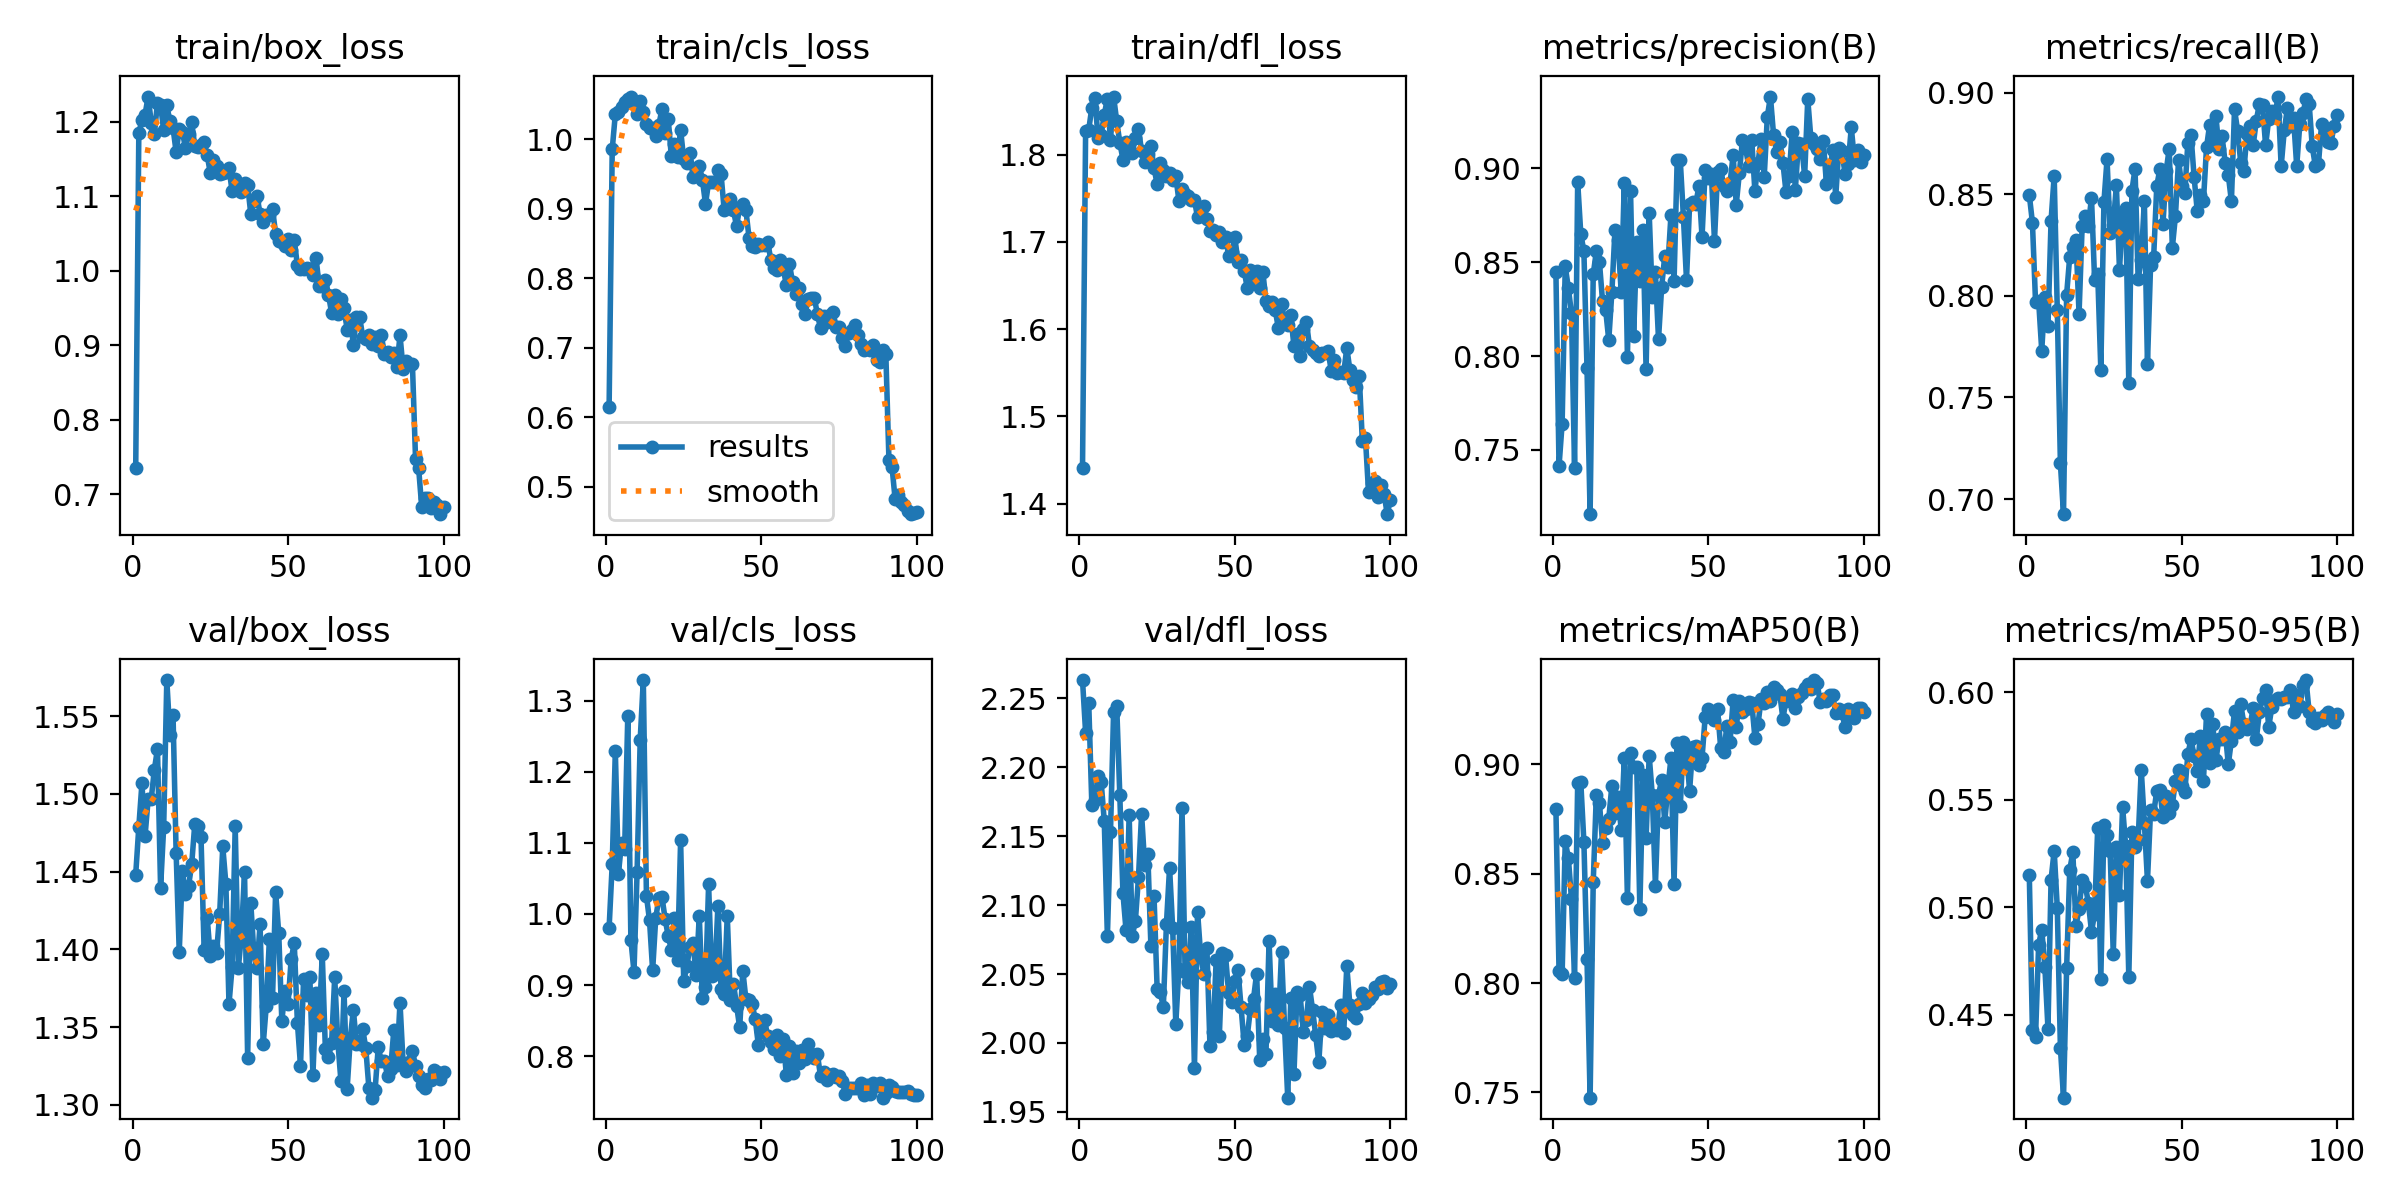

In [ ]:
Image(filename='/content/runs/detect/train22222222222/results.png', width=1000)

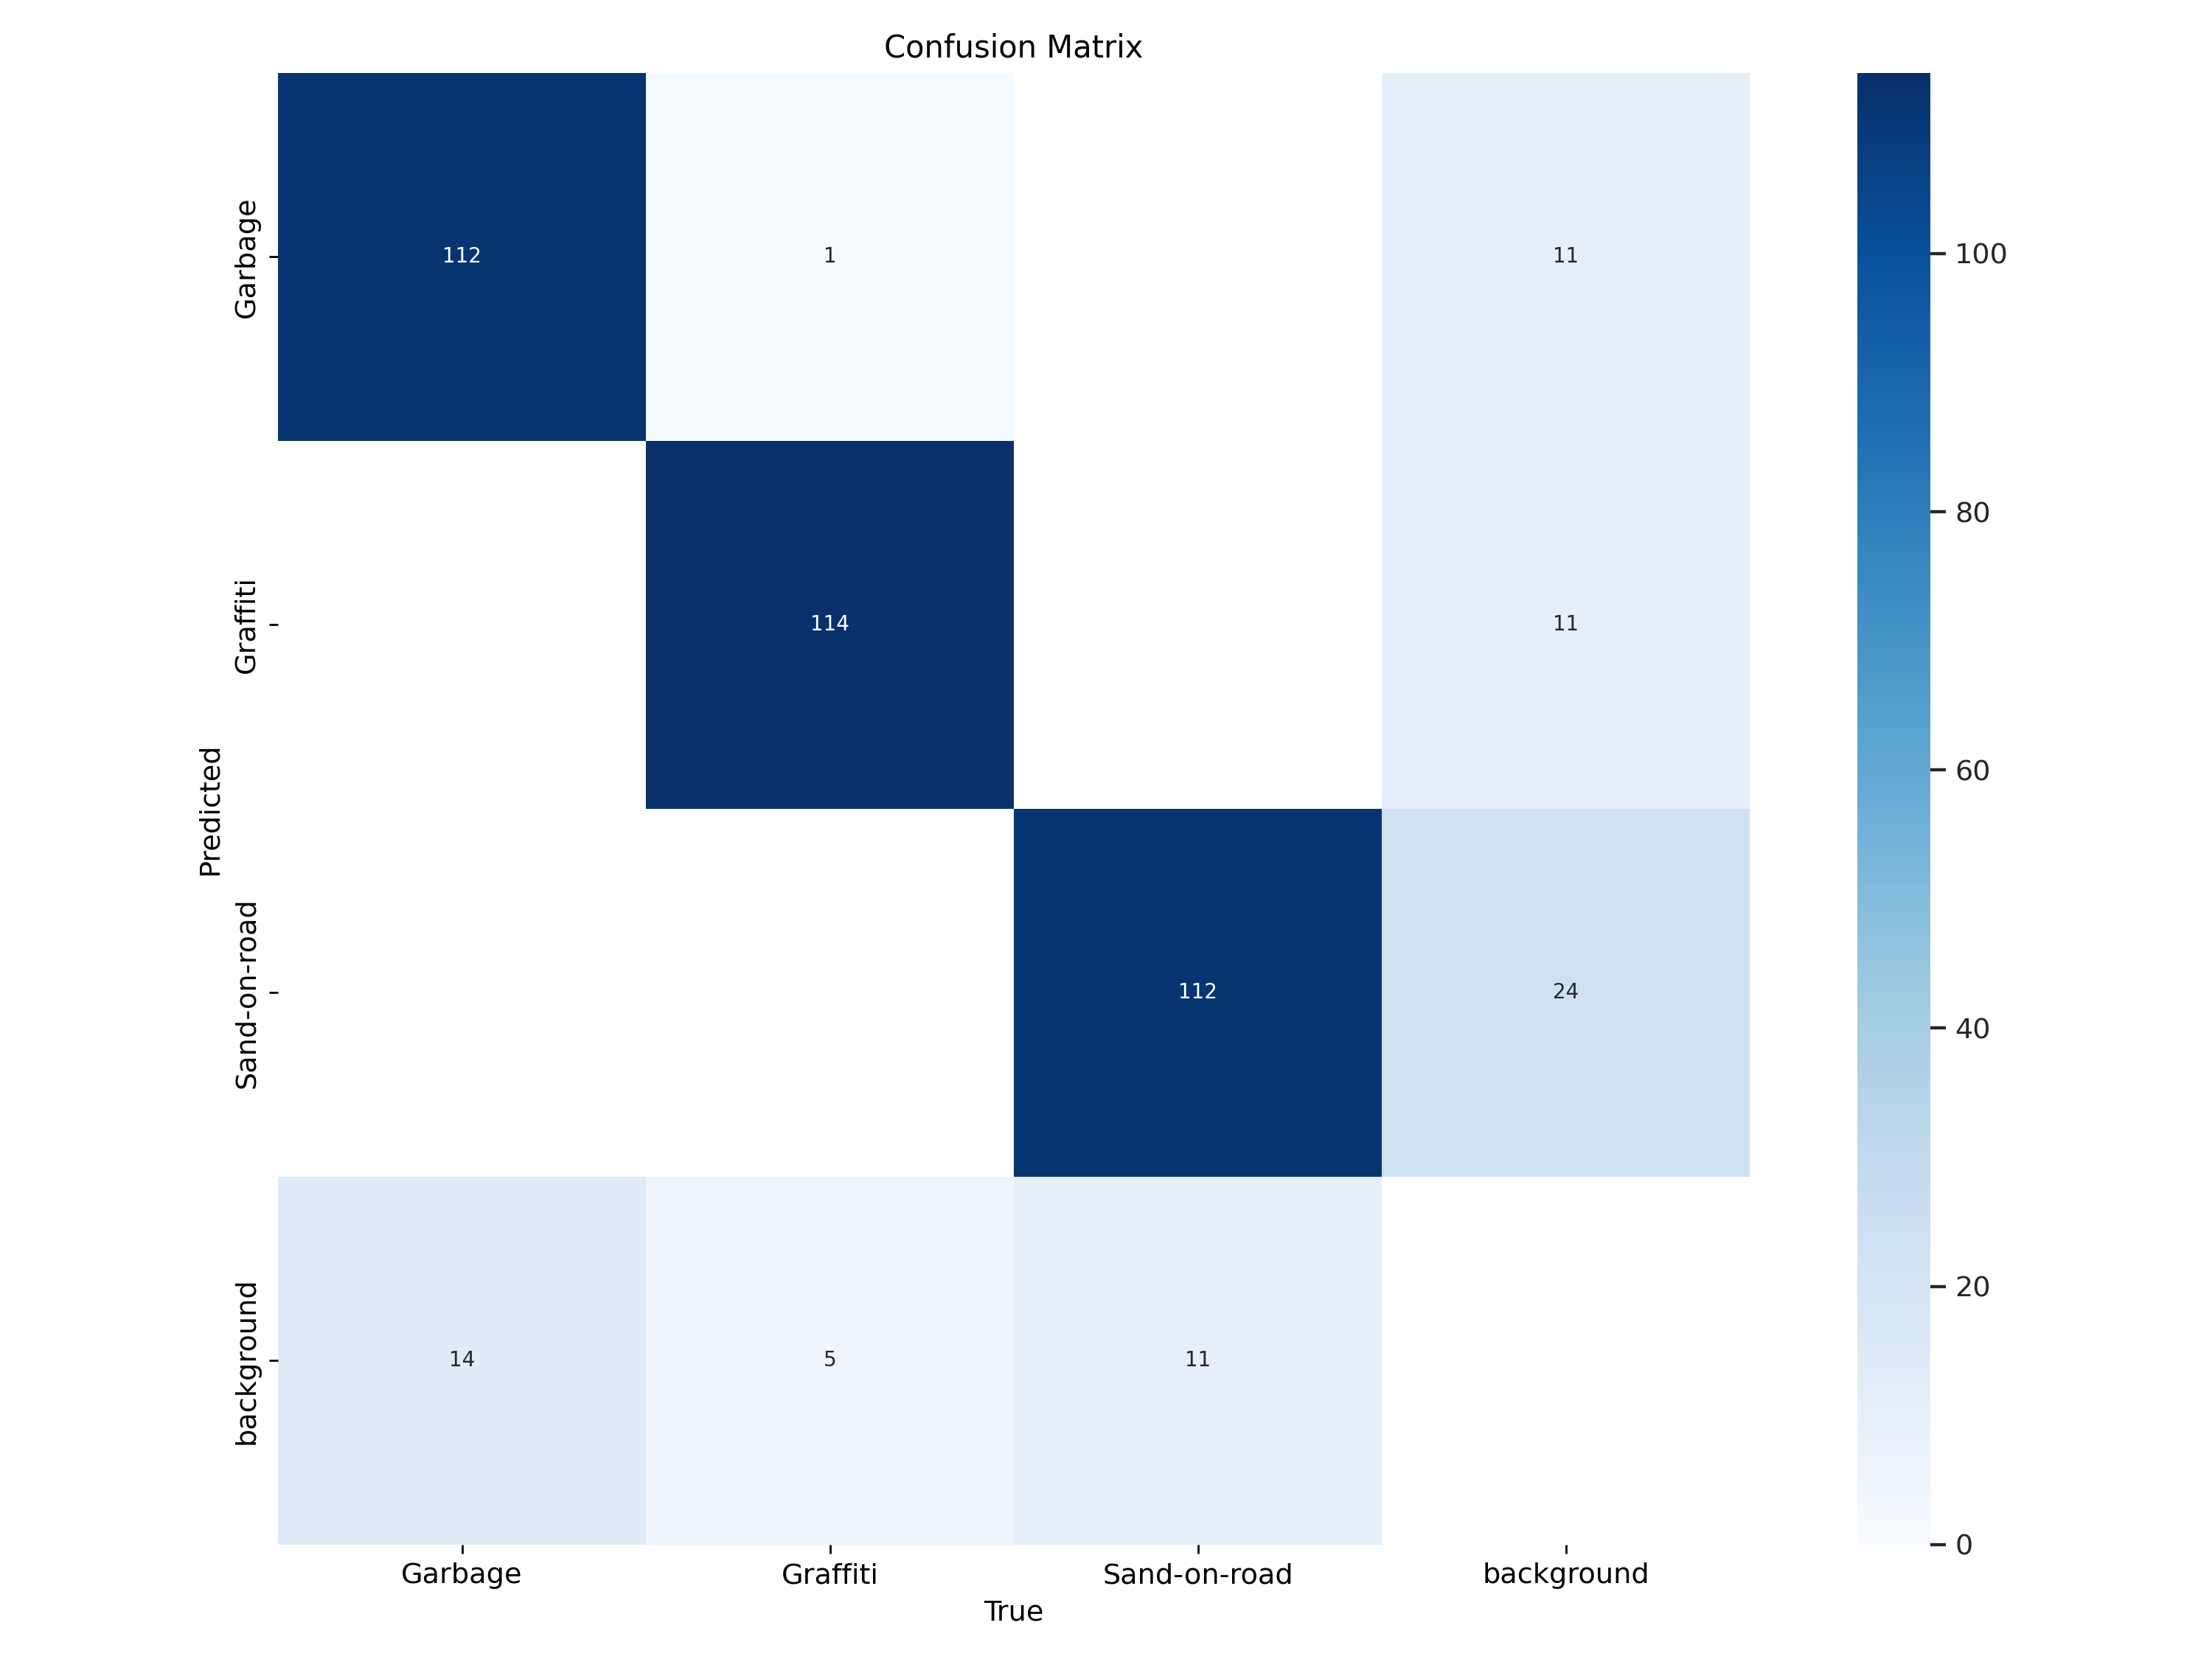

In [ ]:
Image(filename='/content/runs/detect/train22222222222/confusion_matrix.png', width=1000)

validation

In [ ]:
yolo_res_custom = YOLO('/content/runs/detect/train22222222222/weights/best.pt')  # load a custom model
val = yolo_res_custom.val(data='/content/data.yaml')

Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 293 layers, 114,477,977 parameters, 0 gradients, 420.7 GFLOPs


val: Scanning /content/valid/labels.cache... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.78it/s]


                   all        360        369       0.91      0.897      0.932      0.605
               Garbage        120        126      0.909      0.881      0.911      0.581
              Graffiti        120        120      0.934      0.925      0.957      0.668
          Sand-on-road        120        123      0.886      0.884      0.927      0.565
Speed: 0.2ms preprocess, 8.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val


Testing

In [ ]:
test = yolo_res_custom.val(data='/content/data.yaml', split='test')

Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)


val: Scanning /content/test/labels... 360 images, 0 backgrounds, 0 corrupt: 100%|██████████| 360/360 [00:00<00:00, 1118.78it/s]

val: New cache created: /content/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.84it/s]


                   all        360        368      0.879      0.856      0.903      0.534
               Garbage        120        123      0.886      0.846      0.894      0.521
              Graffiti        120        122      0.862      0.893       0.92      0.538
          Sand-on-road        120        123      0.889      0.829      0.894      0.544
Speed: 0.1ms preprocess, 7.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val2
